In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 16.7 MB/s eta 0:00:00


In [ ]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import boxcox

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
#from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)
train = pd.read_csv('/content/drive/MyDrive/electric/train.csv')
train.drop(['num_date_time'],axis=1,inplace=True)
test = pd.read_csv('/content/drive/MyDrive/electric/test.csv')
test.drop(['num_date_time'],axis=1,inplace=True)
train

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  일사(MJ/m2)  \
0          1  20220601 00   18.6      NaN      0.9   42.0     NaN        NaN   
1          1  20220601 01   18.0      NaN      1.1   45.0     NaN        NaN   
2          1  20220601 02   17.7      NaN      1.5   45.0     NaN        NaN   
3          1  20220601 03   16.7      NaN      1.4   48.0     NaN        NaN   
4          1  20220601 04   18.4      NaN      2.8   43.0     NaN        NaN   
...      ...          ...    ...      ...      ...    ...     ...        ...   
203995   100  20220824 19   23.1      NaN      0.9   86.0     0.5        NaN   
203996   100  20220824 20   22.4      NaN      1.3   86.0     0.0        NaN   
203997   100  20220824 21   21.3      NaN      1.0   92.0     NaN        NaN   
203998   100  20220824 22   21.0      NaN      0.3   94.0     NaN        NaN   
203999   100  20220824 23   20.7      NaN      0.1   95.0     NaN        NaN   

        전력소비량(kWh)  
0          1085.28  
1          1047.36  
2           974.88  
3           953.76  
4           986.40  
...            ...  
203995      881.04  
203996      798.96  
203997      825.12  
203998      640.08  
203999      540.24  

[204000 rows x 9 columns]

In [ ]:
train.drop(['일조(hr)', '일사(MJ/m2)'],axis=1,inplace=True)
train

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  전력소비량(kWh)
0          1  20220601 00   18.6      NaN      0.9   42.0     1085.28
1          1  20220601 01   18.0      NaN      1.1   45.0     1047.36
2          1  20220601 02   17.7      NaN      1.5   45.0      974.88
3          1  20220601 03   16.7      NaN      1.4   48.0      953.76
4          1  20220601 04   18.4      NaN      2.8   43.0      986.40
...      ...          ...    ...      ...      ...    ...         ...
203995   100  20220824 19   23.1      NaN      0.9   86.0      881.04
203996   100  20220824 20   22.4      NaN      1.3   86.0      798.96
203997   100  20220824 21   21.3      NaN      1.0   92.0      825.12
203998   100  20220824 22   21.0      NaN      0.3   94.0      640.08
203999   100  20220824 23   20.7      NaN      0.1   95.0      540.24

[204000 rows x 7 columns]

In [ ]:
# '풍속(m/s)' 및 '습도(%)' 피처에 대한 NaN 값은 이전 값으로 채워줍니다.
train['풍속(m/s)'] = train['풍속(m/s)'].fillna(method='ffill')
train['습도(%)'] = train['습도(%)'].fillna(method='ffill')

# '강수량(mm)' 피처의 NaN 값은 0으로 채워줍니다.
train['강수량(mm)'] = train['강수량(mm)'].fillna(0)

# '풍속(m/s)' 및 '습도(%)' 피처에 대한 NaN 값은 이전 값으로 채워줍니다.
test['풍속(m/s)'] = test['풍속(m/s)'].fillna(method='ffill')
test['습도(%)'] = test['습도(%)'].fillna(method='ffill')

# '강수량(mm)' 피처의 NaN 값은 0으로 채워줍니다.
test['강수량(mm)'] = test['강수량(mm)'].fillna(0)

In [ ]:

## 변수들을 영문명으로 변경
cols = ['num', 'date_time', 'temp', 'rainy' ,'wind','hum' , 'power']
train.columns = cols

# 'date_time' 컬럼을 문자열로 변환
train['date_time'] = train['date_time'].astype(str)

date = pd.to_datetime(train.date_time, format='%Y%m%d %H')
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.isocalendar().week


cols = ['num', 'date_time', 'temp', 'rainy' ,'wind','hum']
test.columns = cols

# 'date_time' 컬럼을 문자열로 변환
test['date_time'] = test['date_time'].astype(str)

date = pd.to_datetime(test.date_time, format='%Y%m%d %H')
test['hour'] = date.dt.hour
test['day'] = date.dt.weekday
test['month'] = date.dt.month
test['week'] = date.dt.isocalendar().week
test

num    date_time  temp  rainy  wind  hum  hour  day  month  week
0        1  20220825 00  23.5    0.0   2.2   72     0    3      8    34
1        1  20220825 01  23.0    0.0   0.9   72     1    3      8    34
2        1  20220825 02  22.7    0.0   1.5   75     2    3      8    34
3        1  20220825 03  22.1    0.0   1.3   78     3    3      8    34
4        1  20220825 04  21.8    0.0   1.0   77     4    3      8    34
...    ...          ...   ...    ...   ...  ...   ...  ...    ...   ...
16795  100  20220831 19  22.5    0.0   0.9   84    19    2      8    35
16796  100  20220831 20  20.7    0.0   0.4   95    20    2      8    35
16797  100  20220831 21  20.2    0.0   0.4   98    21    2      8    35
16798  100  20220831 22  20.1    0.0   1.1   97    22    2      8    35
16799  100  20220831 23  19.1    0.0   0.1   99    23    2      8    35

[16800 rows x 10 columns]

In [ ]:
train['week'] = train['week'].astype('int')
test['week'] = test['week'].astype('int')

In [ ]:
# 같은 건물? 그루핑

df = train[['date_time', 'num', 'temp', 'wind', 'hum']]

# 'date_time'이 특정 시점인 데이터에서 'temp'와 'wind'가 같은 건물 그룹 생성
group_df = df[df['date_time'] == '20220601 00'].groupby(['temp', 'wind', 'hum']).ngroup()

# 각 'num'에 대응시키기 위해 'num'과 그룹 번호를 매핑
num_group_map = df[df['date_time'] == '20220601 00'][['num']].join(group_df.rename('group'), how='inner').set_index('num')['group'].to_dict()

# 매핑한 그룹 번호를 기존 데이터프레임에 적용
train['group'] = df['num'].map(num_group_map)
test['group'] = test['num'].map(num_group_map)
test

num    date_time  temp  rainy  wind  hum  hour  day  month  week  group
0        1  20220825 00  23.5    0.0   2.2   72     0    3      8    34     14
1        1  20220825 01  23.0    0.0   0.9   72     1    3      8    34     14
2        1  20220825 02  22.7    0.0   1.5   75     2    3      8    34     14
3        1  20220825 03  22.1    0.0   1.3   78     3    3      8    34     14
4        1  20220825 04  21.8    0.0   1.0   77     4    3      8    34     14
...    ...          ...   ...    ...   ...  ...   ...  ...    ...   ...    ...
16795  100  20220831 19  22.5    0.0   0.9   84    19    2      8    35      4
16796  100  20220831 20  20.7    0.0   0.4   95    20    2      8    35      4
16797  100  20220831 21  20.2    0.0   0.4   98    21    2      8    35      4
16798  100  20220831 22  20.1    0.0   1.1   97    22    2      8    35      4
16799  100  20220831 23  19.1    0.0   0.1   99    23    2      8    35      4

[16800 rows x 11 columns]

In [ ]:
train['tem_x_hum'] = train['temp'] * train['hum']
test['tem_x_hum'] = test['temp'] * test['hum']

group_target_mean = train.groupby('group')['power'].mean()
group_target_mean.name = 'group_target_mean'

train = train.join(group_target_mean, on='group')
test = test.join(group_target_mean, on='group')
train

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0         1  20220601 00  18.6    0.0   0.9  42.0  1085.28     0    2      6   
1         1  20220601 01  18.0    0.0   1.1  45.0  1047.36     1    2      6   
2         1  20220601 02  17.7    0.0   1.5  45.0   974.88     2    2      6   
3         1  20220601 03  16.7    0.0   1.4  48.0   953.76     3    2      6   
4         1  20220601 04  18.4    0.0   2.8  43.0   986.40     4    2      6   
...     ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
203995  100  20220824 19  23.1    0.0   0.9  86.0   881.04    19    2      8   
203996  100  20220824 20  22.4    0.0   1.3  86.0   798.96    20    2      8   
203997  100  20220824 21  21.3    0.0   1.0  92.0   825.12    21    2      8   
203998  100  20220824 22  21.0    0.0   0.3  94.0   640.08    22    2      8   
203999  100  20220824 23  20.7    0.0   0.1  95.0   540.24    23    2      8   

        week  group  tem_x_hum  group_target_mean  
0         22     14      781.2        3156.037251  
1         22     14      810.0        3156.037251  
2         22     14      796.5        3156.037251  
3         22     14      801.6        3156.037251  
4         22     14      791.2        3156.037251  
...      ...    ...        ...                ...  
203995    34      4     1986.6         824.705176  
203996    34      4     1926.4         824.705176  
203997    34      4     1959.6         824.705176  
203998    34      4     1974.0         824.705176  
203999    34      4     1966.5         824.705176  

[204000 rows x 14 columns]

In [ ]:
train['group'].value_counts() / 2040

14    31.0
11    15.0
25     7.0
13     6.0
15     5.0
16     5.0
26     3.0
0      3.0
12     2.0
21     2.0
19     2.0
22     2.0
5      2.0
2      1.0
10     1.0
8      1.0
7      1.0
3      1.0
17     1.0
20     1.0
18     1.0
24     1.0
6      1.0
23     1.0
1      1.0
9      1.0
27     1.0
4      1.0
Name: group, dtype: float64

In [ ]:
group_13 = train[train['group'] == 25]
mean_values = group_13.groupby(['num', 'day'])['power'].mean()

print(mean_values)


num  day
40   0      1580.240625
     1      1881.470833
     2      1892.948077
     3      1861.744271
     4      1890.427083
     5      2066.970833
     6      2047.053646
48   0      1965.683750
     1      1993.518750
     2      1943.742692
     3      1962.341250
     4      1969.641250
     5      1683.350000
     6      1665.765000
49   0      3155.076875
     1      3200.821250
     2      3118.451538
     3      3135.717500
     4      3148.349375
     5      2815.588750
     6      2806.890000
55   0      1030.537083
     1      1044.120833
     2      1033.108462
     3      1038.612083
     4      1032.147083
     5       945.434167
     6       937.644583
65   0       589.144375
     1       579.193125
     2       549.646154
     3       545.310313
     4       558.484375
     5       581.480937
     6       620.018125
72   0      1309.631875
     1      1357.126250
     2      1320.527308
     3      1317.726562
     4      1327.004687
     5      1163.740000
     6 

In [ ]:
cnt = 0
for num in range(1, 101):
    weekday_mean_power = train[(train['num'] == num) & (train['day'] < 5)]['power'].mean()
    weekend_mean_power = train[(train['num'] == num) & (train['day'] >= 5)]['power'].mean()
    if weekend_mean_power > weekday_mean_power:
        print(f"num {num}: 주말 = {weekend_mean_power} is greater than 평일 = {weekday_mean_power}")
        cnt+=1
    #else:
        #print(f"num {num}: 평일 = {weekday_mean_power} is greater than 주말 = {weekend_mean_power}")
print(cnt)

num 2: 주말 = 1751.505 is greater than 평일 = 1647.7097950819673
num 3: 주말 = 1497.756875 is greater than 평일 = 1422.9591393442622
num 4: 주말 = 1001.1265625000001 is greater than 평일 = 993.1831352459017
num 5: 주말 = 3856.0049999999997 is greater than 평일 = 2299.591721311476
num 32: 주말 = 9875.36125 is greater than 평일 = 9862.015327868854
num 34: 주말 = 3360.8900000000003 is greater than 평일 = 3349.486967213115
num 35: 주말 = 2173.8614583333333 is greater than 평일 = 2171.776639344262
num 37: 주말 = 3469.5375000000004 is greater than 평일 = 3306.1346311475413
num 38: 주말 = 1888.0412499999995 is greater than 평일 = 1782.2682786885243
num 39: 주말 = 2239.7158333333336 is greater than 평일 = 2143.220655737705
num 40: 주말 = 2057.012239583333 is greater than 평일 = 1822.5396516393441
num 41: 주말 = 3438.8072916666665 is greater than 평일 = 3206.682991803279
num 42: 주말 = 1624.4656249999998 is greater than 평일 = 1584.2127049180326
num 43: 주말 = 2039.6697916666662 is greater than 평일 = 1835.66987704918
num 44: 주말 = 2285.4141666666665

In [ ]:
cnt = 0
for num in range(1, 101):
    weekday_mean_power = train[(train['num'] == num) & (train['day'] < 5)]['power'].mean()
    weekend_mean_power = train[(train['num'] == num) & (train['day'] >= 5)]['power'].mean()
    if abs(weekday_mean_power - weekend_mean_power) / weekday_mean_power > 0.1:
        print(f"num {num}: 평일 = {weekday_mean_power} is greater than 주말 = {weekend_mean_power}")
        cnt+=1

print(cnt)

num 1: 평일 = 2734.6881967213117 is greater than 주말 = 2445.451666666667
num 5: 평일 = 2299.591721311476 is greater than 주말 = 3856.0049999999997
num 7: 평일 = 819.8648360655739 is greater than 주말 = 654.4518750000001
num 8: 평일 = 1368.4435245901639 is greater than 주말 = 1223.3043750000002
num 14: 평일 = 1996.763606557377 is greater than 주말 = 1686.025
num 15: 평일 = 1838.6128586065574 is greater than 주말 = 1629.3746093749999
num 17: 평일 = 1129.4810040983607 is greater than 주말 = 591.2234375
num 18: 평일 = 1583.2650614754098 is greater than 주말 = 1124.4036458333333
num 19: 평일 = 1582.2964412568303 is greater than 주말 = 1020.2728125
num 20: 평일 = 2030.2904918032789 is greater than 주말 = 941.2175000000001
num 21: 평일 = 2237.440198087432 is greater than 주말 = 1357.9179311336804
num 22: 평일 = 1317.247868852459 is greater than 주말 = 1028.2312499999998
num 23: 평일 = 1339.760655737705 is greater than 주말 = 1072.6828125000002
num 24: 평일 = 10687.412704918032 is greater than 주말 = 8406.78125
num 25: 평일 = 7811.917131147541 is gr

In [ ]:
# 'num'과 'day'에 대해 반복
for num in range(1, 101):
    for day in range(7):
        mean_power = train[(train['num'] == num) & (train['day'] == day)]['power'].mean()
        print(f"num {num}, Day {day}: Mean Power = {mean_power}")

    print("=====================================================")

num 1, Day 0: Mean Power = 2716.506666666666
num 1, Day 1: Mean Power = 2784.75
num 1, Day 2: Mean Power = 2682.7969230769236
num 1, Day 3: Mean Power = 2704.5983333333334
num 1, Day 4: Mean Power = 2789.1133333333332
num 1, Day 5: Mean Power = 2625.706666666667
num 1, Day 6: Mean Power = 2265.1966666666667
num 2, Day 0: Mean Power = 1215.2125000000003
num 2, Day 1: Mean Power = 1751.01125
num 2, Day 2: Mean Power = 1750.3003846153845
num 2, Day 3: Mean Power = 1757.585
num 2, Day 4: Mean Power = 1755.8906250000002
num 2, Day 5: Mean Power = 1802.625
num 2, Day 6: Mean Power = 1700.385
num 3, Day 0: Mean Power = 1141.8300000000002
num 3, Day 1: Mean Power = 1470.4550000000002
num 3, Day 2: Mean Power = 1453.5646153846155
num 3, Day 3: Mean Power = 1492.265
num 3, Day 4: Mean Power = 1554.130625
num 3, Day 5: Mean Power = 1560.0749999999998
num 3, Day 6: Mean Power = 1435.43875
num 4, Day 0: Mean Power = 1004.2668749999999
num 4, Day 1: Mean Power = 996.4293750000002
num 4, Day 2: Mean 

In [ ]:
# 'num'과 'day'에 대해 반복
for num in range(0, 27):  # num은 1에서 100까지
    for day in range(7):  # day는 0에서 6까지
        mean_power = train[(train['group'] == num) & (train['day'] == day)]['power'].mean()
        print(f"group {num}, Day {day}: Mean Power = {mean_power}")
    print("=====================================================")

group 0, Day 0: Mean Power = 1770.925138888889
group 0, Day 1: Mean Power = 1748.8726388888888
group 0, Day 2: Mean Power = 1715.3760897435898
group 0, Day 3: Mean Power = 1706.5006944444447
group 0, Day 4: Mean Power = 1754.6113888888888
group 0, Day 5: Mean Power = 1788.7727083333334
group 0, Day 6: Mean Power = 1780.1040972222222
group 1, Day 0: Mean Power = 1336.8975
group 1, Day 1: Mean Power = 1323.391875
group 1, Day 2: Mean Power = 1299.1892307692308
group 1, Day 3: Mean Power = 1293.9740625000002
group 1, Day 4: Mean Power = 1314.9250000000002
group 1, Day 5: Mean Power = 1352.65625
group 1, Day 6: Mean Power = 1105.5325
group 2, Day 0: Mean Power = 3762.08
group 2, Day 1: Mean Power = 3881.463333333333
group 2, Day 2: Mean Power = 3764.2461538461534
group 2, Day 3: Mean Power = 3784.888333333333
group 2, Day 4: Mean Power = 3706.98
group 2, Day 5: Mean Power = 2917.1800000000003
group 2, Day 6: Mean Power = 2872.155
group 3, Day 0: Mean Power = 925.9031249999999
group 3, Day 

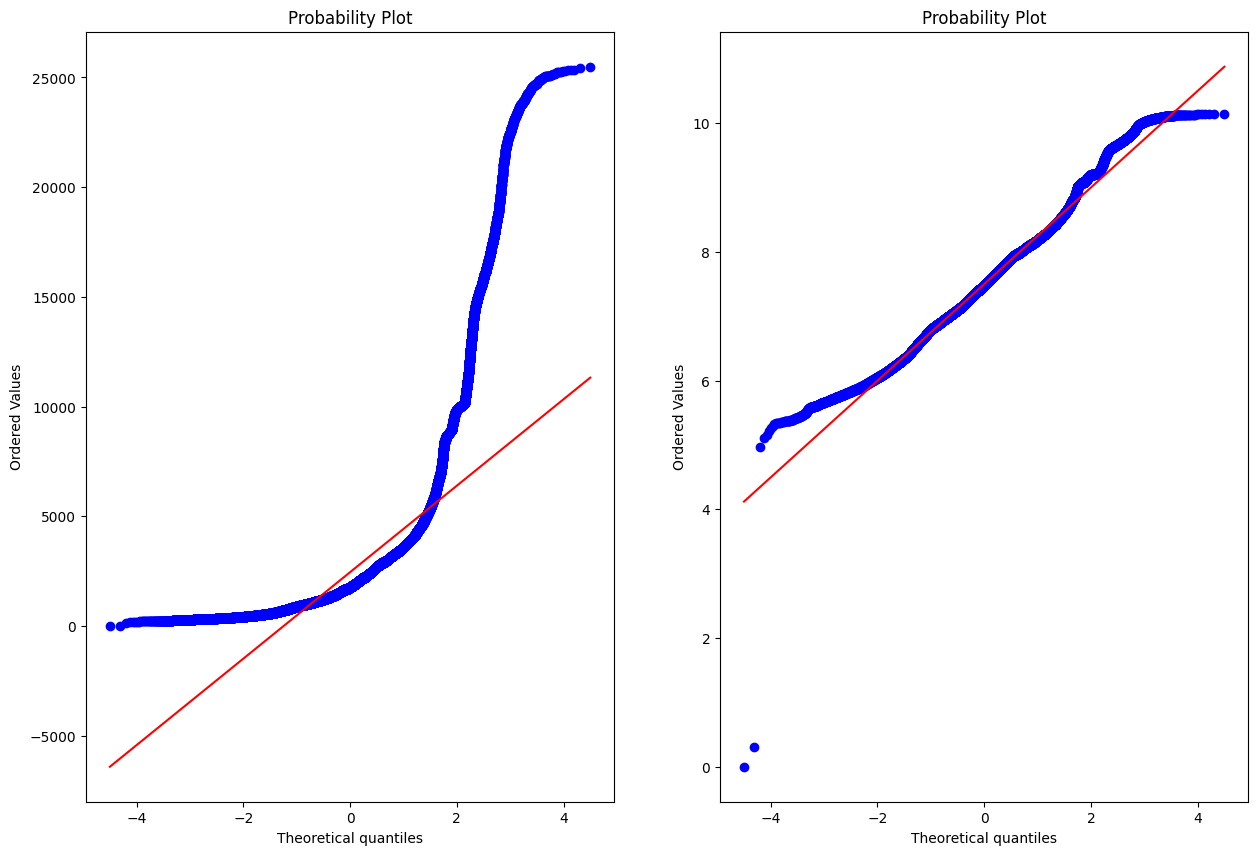

In [ ]:
#로그변환 했을 때 정규분포를 더 따르는지 보는 시각화 코드
from scipy.stats import norm
from scipy import stats
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(train['power'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['power']), plot=plt)

num: 1


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


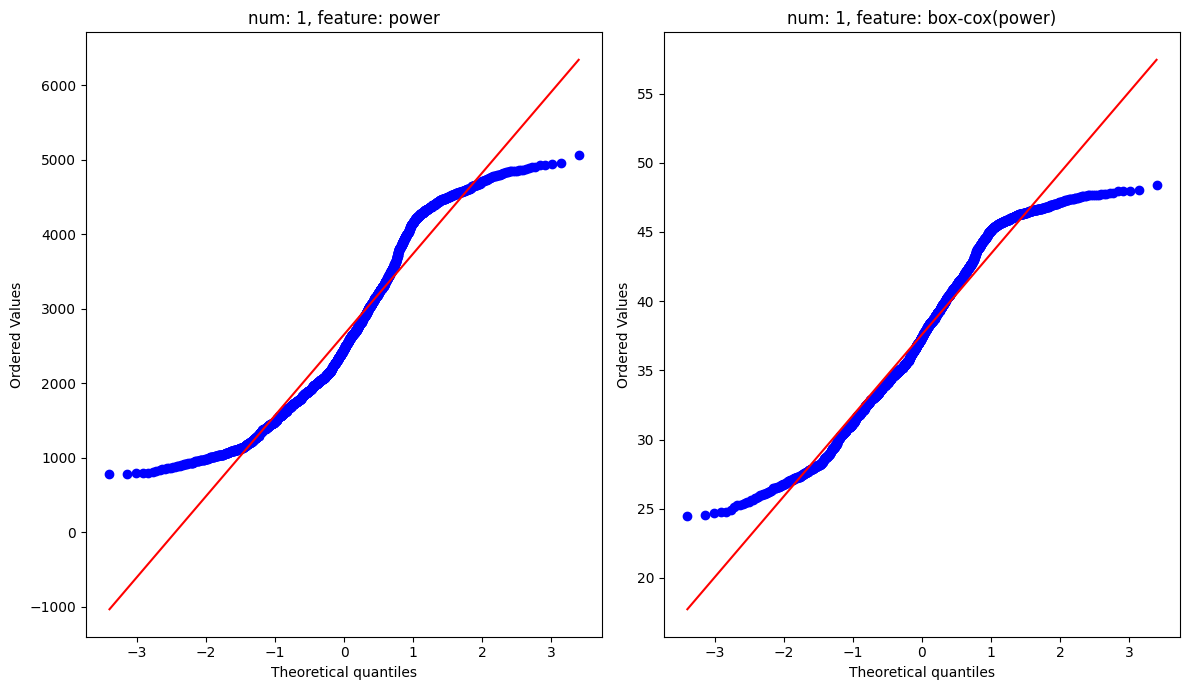

num: 2


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


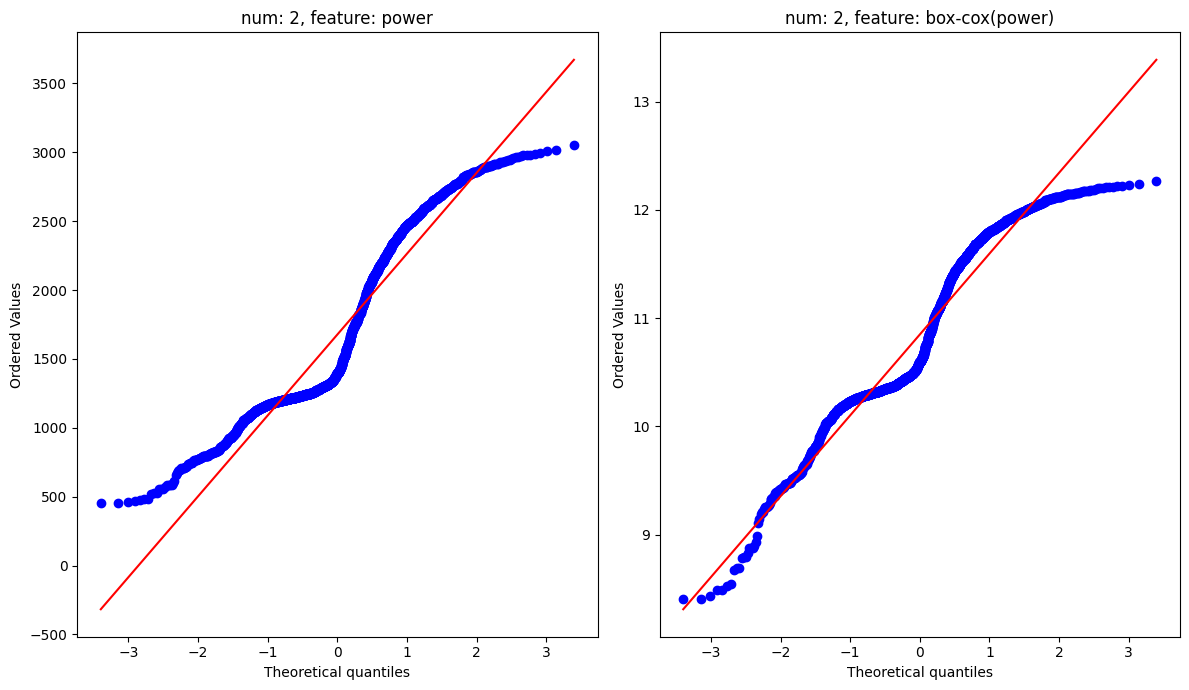

num: 3


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


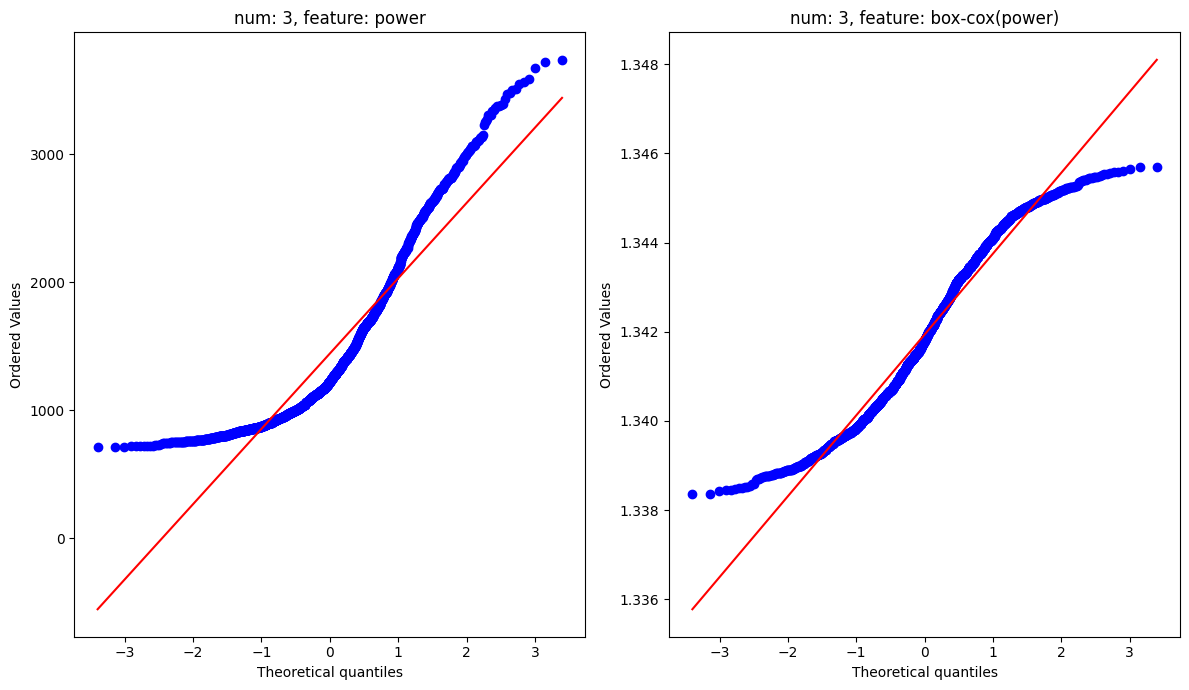

num: 4


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


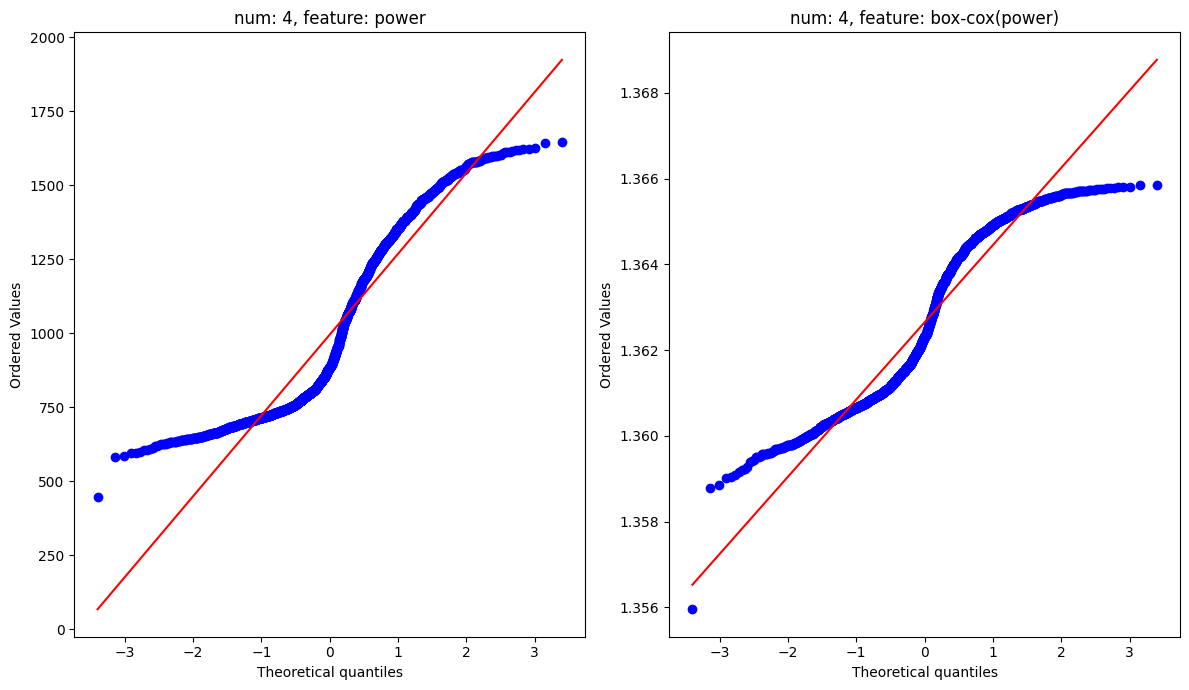

num: 5


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


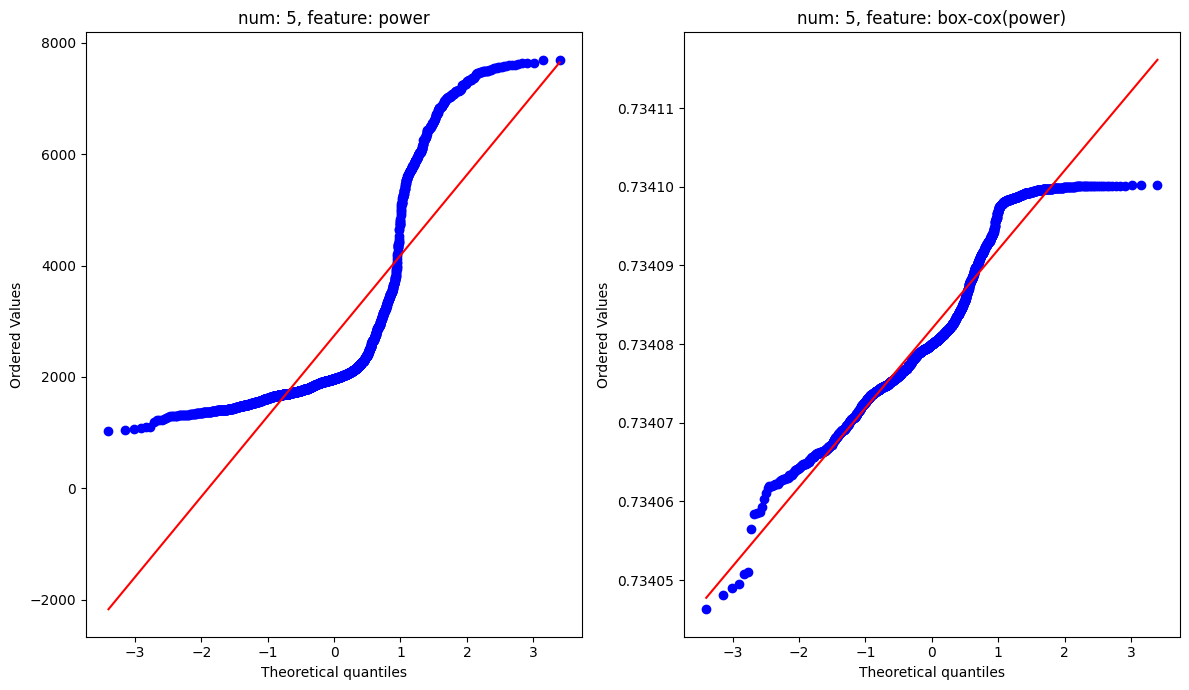

num: 6


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


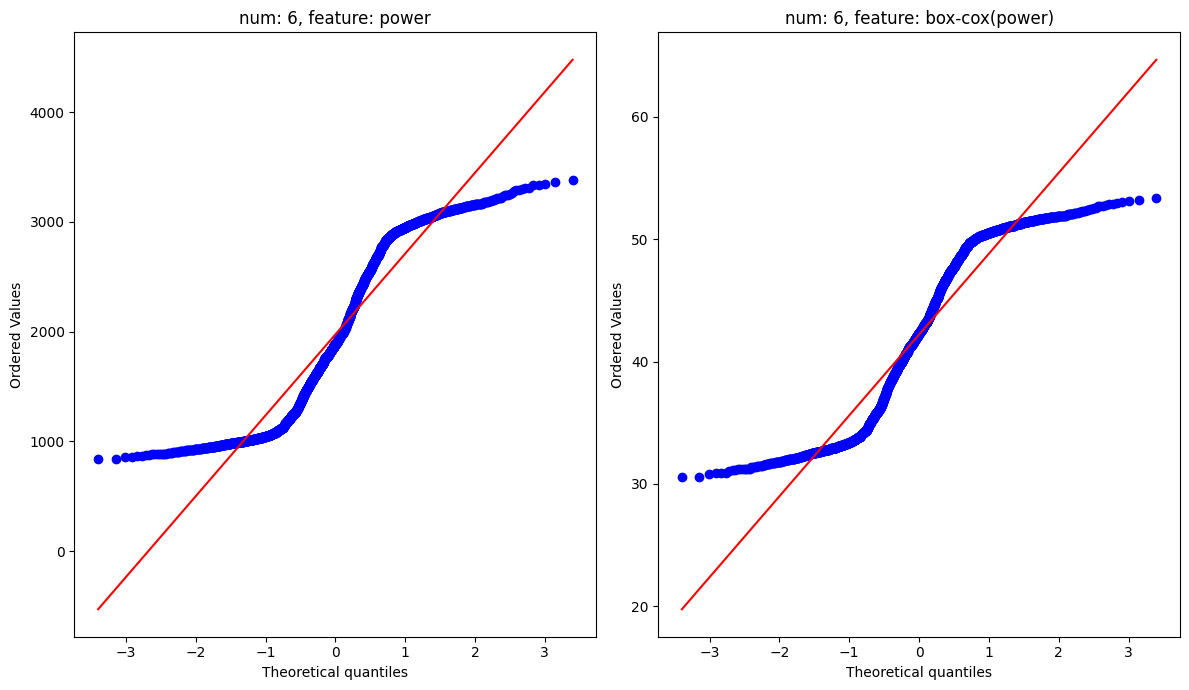

num: 7


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


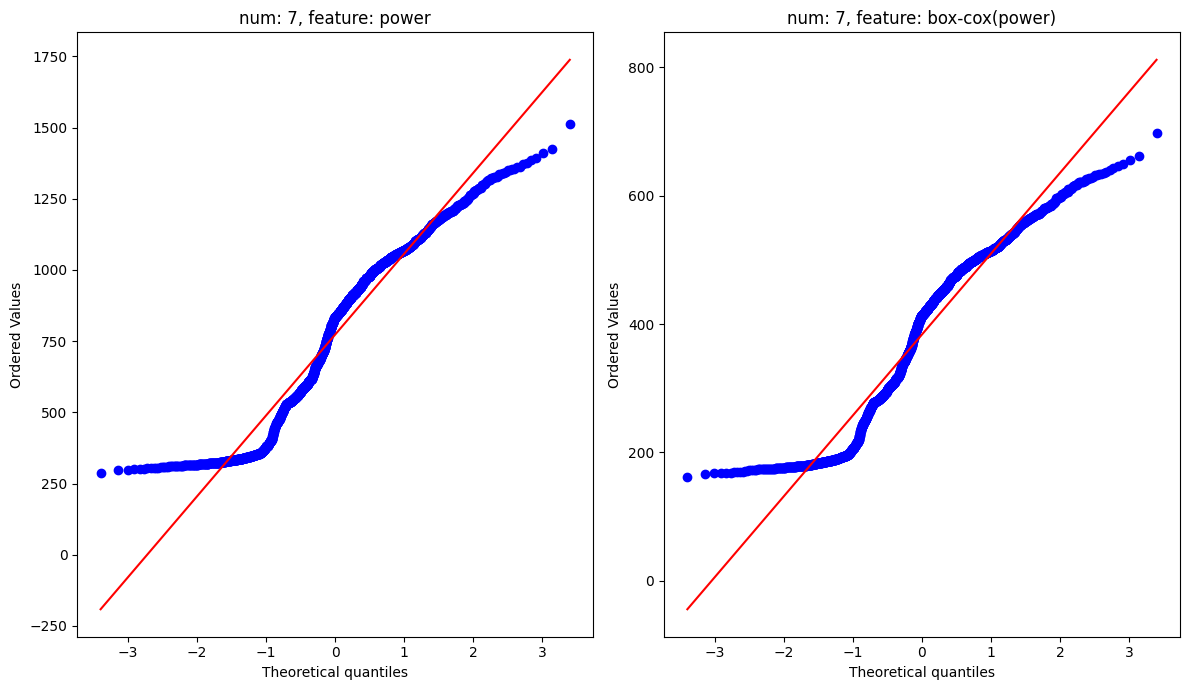

num: 8


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


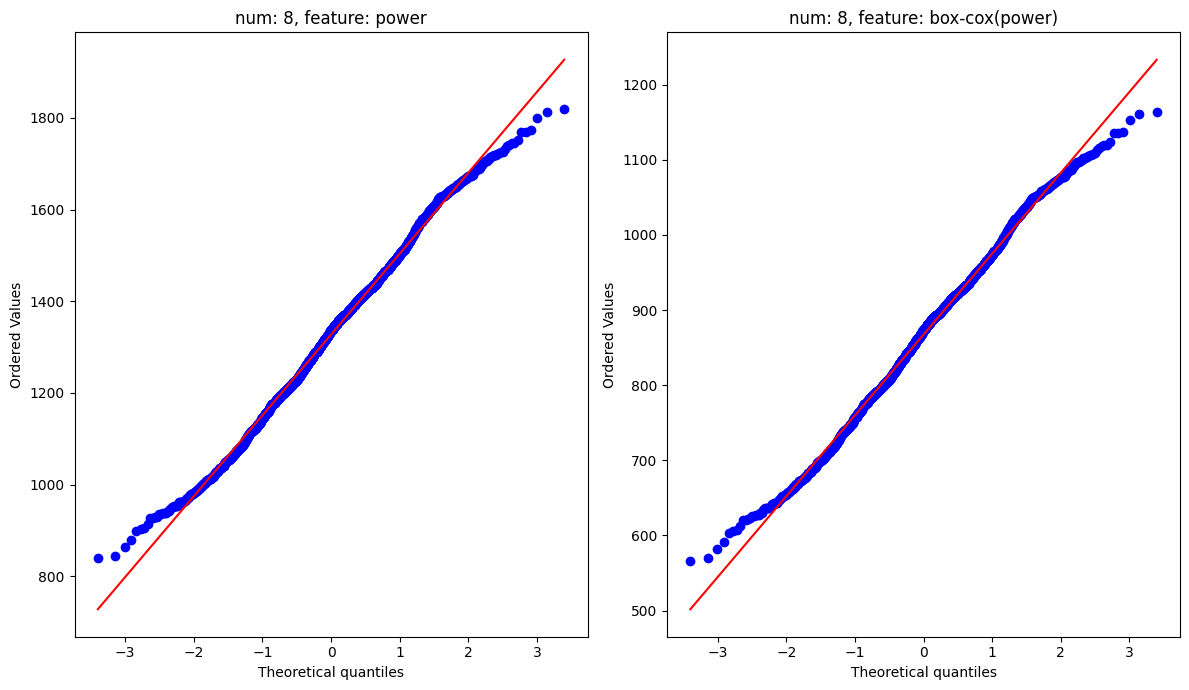

num: 9


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


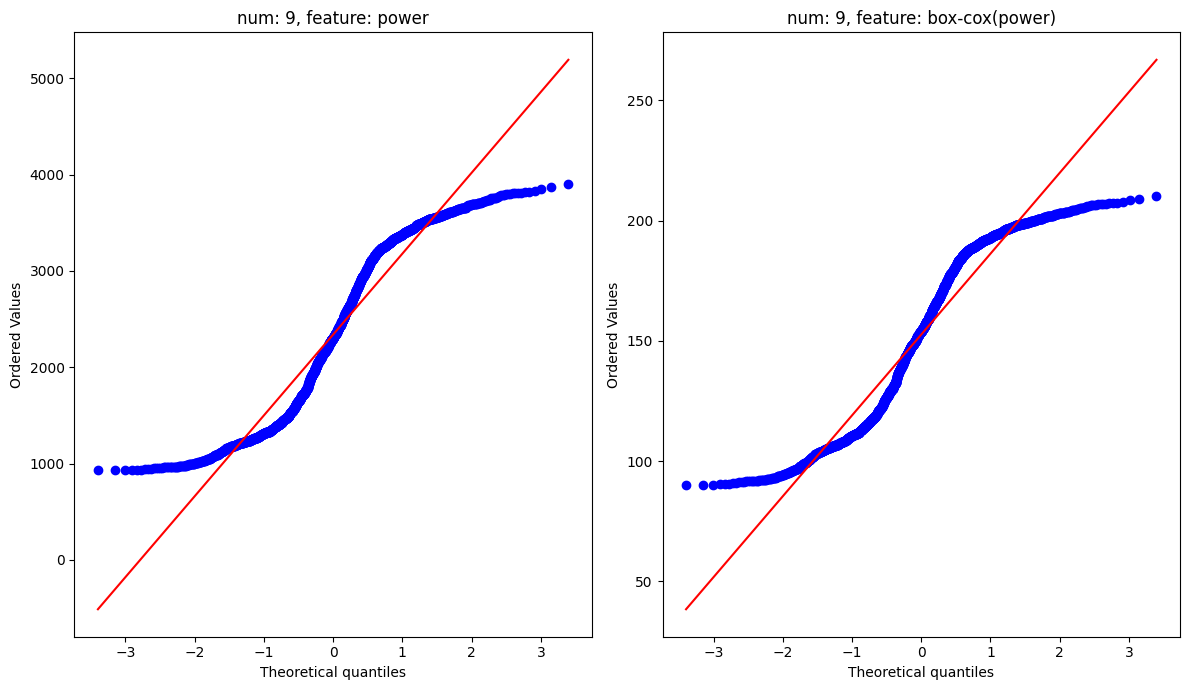

num: 10


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


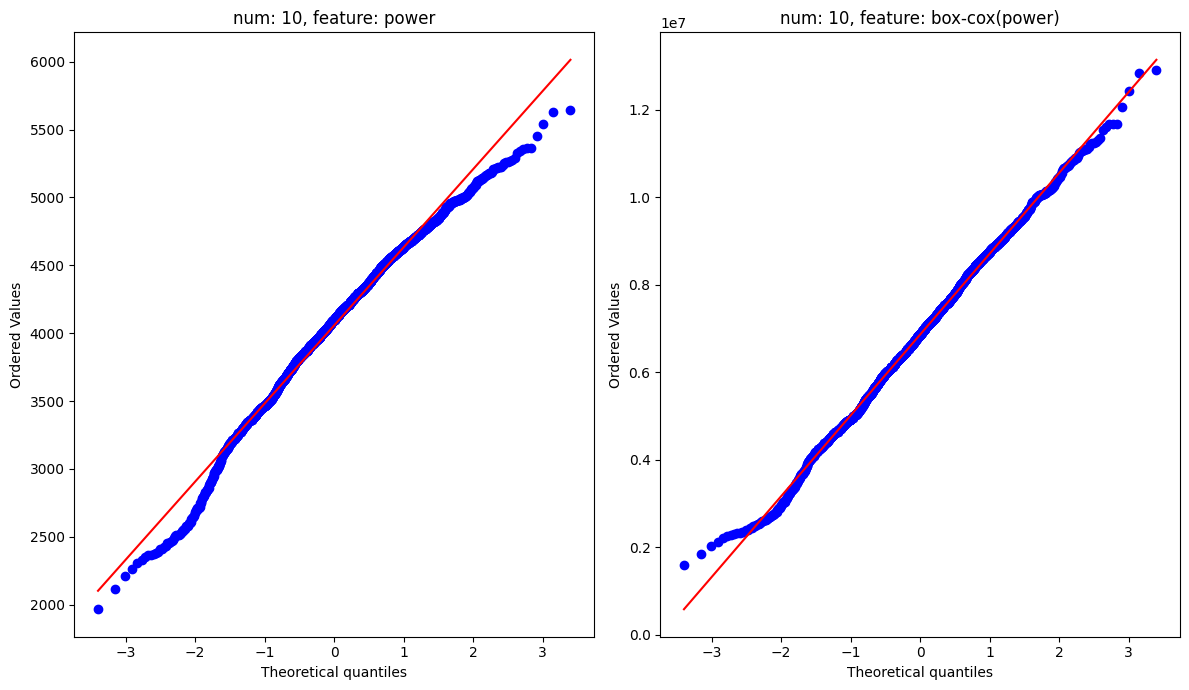

num: 11


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


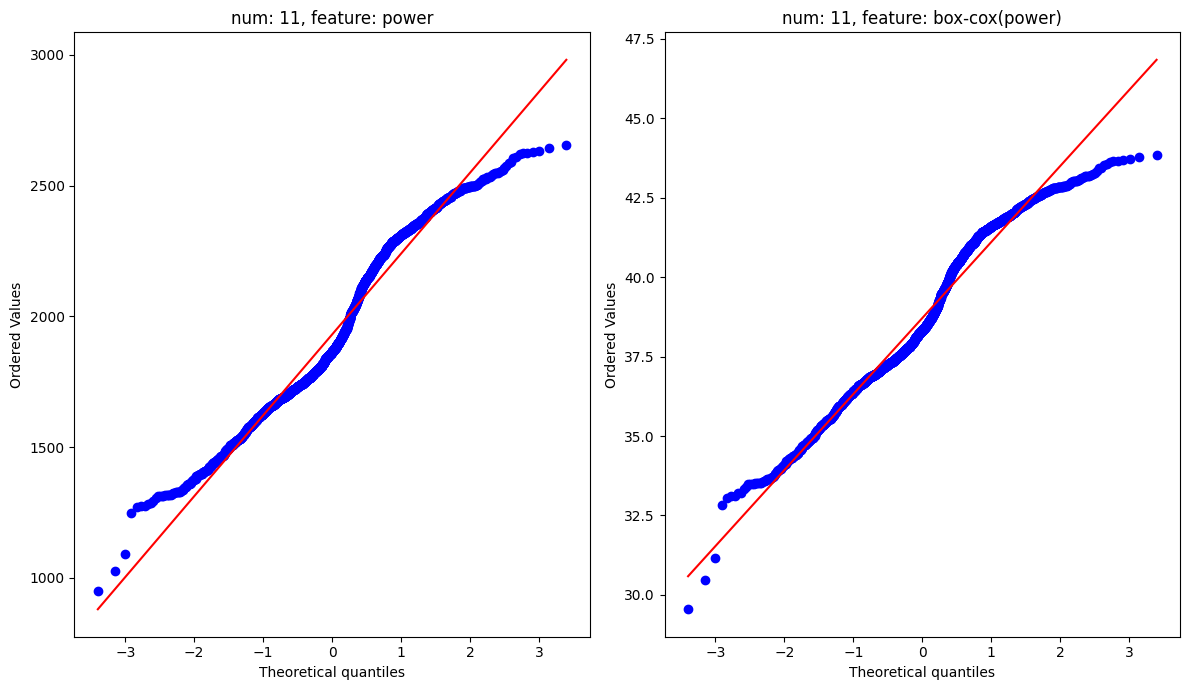

num: 12


<ipython-input-17-51f634ae4727>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)


KeyboardInterrupt: ignored

In [ ]:
from scipy.stats import boxcox

# Loop over each unique 'num'
for num in train['num'].unique():
    print(f"num: {num}")

    # Subset the dataframe by 'num'
    subset = train[train['num'] == num]

    # Apply box-cox transformation
    # Add a small constant to avoid zero values
    subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)

    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=(12, 7))

    # Plot on the first subplot for original 'power'
    ax1 = fig.add_subplot(1, 2, 1)
    res = stats.probplot(subset['power'], plot=plt)
    ax1.set_title(f"num: {num}, feature: power")

    # Plot on the second subplot for box-cox transformed 'power'
    ax2 = fig.add_subplot(1, 2, 2)
    res = stats.probplot(subset['power_boxcox'], plot=plt)
    ax2.set_title(f"num: {num}, feature: box-cox(power)")

    # Show the figure
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import shapiro
from scipy.stats import boxcox

# 건물별로 정규분포 어떤 변환이 더 좋은지 평균값도 구하기
# Loop over each unique 'num'
for num in train['num'].unique():
    print(f"num: {num}")

    # Subset the dataframe by 'num'
    subset = train[train['num'] == num]

    # Perform the Shapiro-Wilk test for 'power'
    stat, p = shapiro(subset['power'])
    print(f"Shapiro-Wilk test for 'power': statistic = {stat}, p-value = {p}")

    # Perform the Shapiro-Wilk test for log-transformed 'power'
    stat, p = shapiro(np.log1p(subset['power']))
    print(f"Shapiro-Wilk test for 'log(power)': statistic = {stat}, p-value = {p}")

    # Perform the Shapiro-Wilk test for box-cox transformed 'power'
    subset['power_boxcox'], _ = boxcox(subset['power'] + 0.001)
    stat, p = shapiro(subset['power_boxcox'])
    print(f"Shapiro-Wilk test for 'box-cox(power)': statistic = {stat}, p-value = {p}")


In [ ]:
# Loop over each unique 'num'
for num in train['num'].unique():
    print(f"num: {num}")

    # Subset the dataframe by 'num'
    subset = train[train['num'] == num]

    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=(12, 7))

    # Plot on the first subplot for original 'power'
    ax1 = fig.add_subplot(1, 2, 1)
    res = stats.probplot(subset['power'], plot=plt)
    ax1.set_title(f"num: {num}, feature: power")

    # Plot on the second subplot for log transformed 'power'
    ax2 = fig.add_subplot(1, 2, 2)
    res = stats.probplot(np.log1p(subset['power']), plot=plt)
    ax2.set_title(f"num: {num}, feature: log(power)")

    # Show the figure
    plt.tight_layout()
    plt.show()


In [ ]:
# Loop over each unique 'num'
for num in train['num'].unique():
    print(f"num: {num}")

    # Subset the dataframe by 'num'
    subset = train[train['num'] == num]

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

    # Plot on the first subplot
    sns.kdeplot(subset['power'], fill=True, ax=axs[0])
    axs[0].set_title(f"num: {num}, feature: power")

    # Plot on the second subplot (add a small constant for log transformation)
    sns.kdeplot(np.log(subset['power'] + 0.001), fill=True, ax=axs[1])
    axs[1].set_title(f"num: {num}, feature: log(power)")

    # Show the figure
    plt.tight_layout()
    plt.show()


- 백화점, 아울렛은 temp 30 이전, 이후로 타겟값 차이가 심함
- train[(train['num'] == 75) & (train['power'] < 550)] 확인 필요
- train[(train['num'] == 77) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] > 2000)]['week'].unique() 와, train[(train['num'] == 77) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 2000)]['week'].unique() 차이가 week 34
- -> 지식산업센터는 week34일때 출근~퇴근시간 사이 무조건 power가 높음
- 할인마트 일부는 week 23, 25, 27일때만 800이하의 power 값이 나옴 train[(train['num'] == 87) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 800)]['week'].unique()

빌딩간 day에 따른 power


1. 건물기타
 - 2,3번 건물은 day 0 일때 power가 급격히 낮음
5번 건물은 day 0~3이 power가 급격히 낮은데 0~3으로 가면서 점점 높아짐

2. 공공
 - 16번 건물은 모든 day가 비슷, 나머지는 5,6이 power 가 급격히 낮음

3. 대학교
 - 모든 건물이 5,6이 power가 낮음

4. 데이터센터
 - 모든 건물이 day가 비슷

5. 백화점및아울렛
 - 모든 건물이 day가 비슷

6. 병원
 - 모든 건물이 day가 비슷한데
 45번,50번은 토요일 진료를 하는듯? 확인 필요

7. 상용
 - 모든 건물이 다 다름
 - 53,55,57,58,5960 : 5,6이 power가 낮음
 - 54번 : 0이 power가 낮음
 - 56번 : 모든 건물이 day가 비슷

8. 아파트
 - 모든 건물이 day가 비슷

9. 연구소
 - 75번빼고 모두 5,6이 power가 낮음
 - 75번은 특이한게 day 0,1,2에 power가 엄청 낮은때가 존재

10. 지식산업센터
 - 81번 빼고 모두 5,6이 power가 낮음
 - 81번은 다 비슷

11. 할인마트
 - 모든 건물이 day가 비슷

12. 호텔 및 리조트
 - 모든 건물이 day가 비슷


- 32, 33번 건물은 6월에 비해 7,8월이 확실히 전력량 상승

In [ ]:
#train의 피처들과 타겟과의 관계 확인

skip_features = ['num', 'group', 'group_target_mean']

# For each feature in the dataframe
for col in train.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # For each unique building number
        for num in train['num'].unique():

            # Subset the dataframe by 'num'
            subset = train[train['num'] == num]

            # Create a new figure
            plt.figure()

            # Plot a scatter plot for this feature and the target
            plt.scatter(subset[col], subset['power'])
            plt.xlabel(col)
            plt.ylabel('power')
            plt.title(f"num: {num}, feature: {col}")

            # Show the plot
            plt.show()


In [ ]:
train[(train['num'] == 34) & (train['power'] < 2800)]

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
68973   34  20220808 21  25.9    1.9   2.1  96.0  2631.24    21    0      8   

       week  tem_x_hum  group  group_target_mean  
68973    32     2486.4     14        3156.037251

In [ ]:
train[(train['num'] == 87) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] > 800)]['week'].unique()

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [ ]:
train[(train['num'] == 87) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 800)]['week'].unique()

array([23, 25, 27, 29, 32])

In [ ]:
train[(train['num'] == 87) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 800)]['week'].unique()

array([23, 25, 27])

In [ ]:
train[(train['num'] == 86) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 900)]['week'].unique()

array([23, 25, 27, 29, 32])

In [ ]:
train[(train['num'] == 85) & (train['hour'] > 10) & (train['hour'] < 16) & (train['power'] < 900)]['week'].unique()

In [ ]:
#train 피처별 시간순서 변화량 시각화

skip_features = ['date_time', 'num',  'group', 'group_target_mean', 'hour', 'day', 'month' ,'week', 'wind', 'rainy']

# For each feature in the dataframe
for col in train.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train[col].dtype, np.number) and col not in skip_features:

        # For each unique building number
        for num in train['num'].unique():

            # Subset the dataframe by 'num'
            subset = train[train['num'] == num]

            # Create a new figure
            plt.figure()

            # Plot a line plot for this feature and the target
            plt.plot(subset['date_time'], subset[col])
            plt.xlabel('') # remove x-axis label
            plt.xticks([]) # remove x-axis ticks
            plt.ylabel(col)
            plt.title(f"num: {num}, feature: {col}")

            # Show the plot
            plt.show()


In [ ]:
#train, test concat해서 피처별 시간순서 변화량 시각화

import seaborn as sns

skip_features = ['date_time', 'power', 'num',  'group', 'group_target_mean', 'hour', 'day', 'month' ,'week', 'wind', 'rainy']

train_x = train.drop(['power'],axis=1)

# Add 'origin' column
train['origin'] = 'train'
test['origin'] = 'test'

df = pd.concat([train,test],axis=0)
df = df.sort_values(by=['num', 'date_time'])

# For each feature in the dataframe
for col in df.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(df[col].dtype, np.number) and col not in skip_features:

        # For each unique building number
        for num in df['num'].unique():

            # Subset the dataframe by 'num'
            subset = df[df['num'] == num]

            # Create a new figure
            plt.figure()

            # Plot a line plot for this feature and the target
            sns.lineplot(x='date_time', y=col, hue='origin', data=subset)
            plt.xlabel('') # remove x-axis label
            plt.xticks([]) # remove x-axis ticks
            plt.ylabel(col)
            plt.title(f"num: {num}, feature: {col}")

            # Show the plot
            plt.show()


### Validation이 이상하게 높게 나온 building들 위주로 EDA
 - 2, 3, 5, 7, 14, 30, 40, 41, 43, 53, 65, 95 + 할인마트는 주말 구분하면 망함

In [ ]:
train[(train['date_time'] == '20220801 13')]['temp'].unique()

array([31.1, 31.5, 31.7, 29.6, 30.4, 30.3, 30.9, 31.4, 30.2, 32.3, 28.4,
       31.8, 28.3, 29.4, 29.1, 29. , 32.6, 29.7, 26.2, 30.5, 25.5, 26.5])

In [ ]:
train[(train['num'] == 1)]['target_scaled'] # wind가 2.4는 서울, wind가 3.0은 수원

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 31.1)] # wind가 2.4는 서울, wind가 3.0은 수원

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 31.5)] # wind가 2.4는 이천, 4.9는 군산

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 31.7)] # wind가 1.9는 부여 3.7은 양산

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 29.6)] # wind가 3.9는 부산, 3.0은 충주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 30.4)] # wind가 3.7은 인천, 2.4는 원주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 30.3)] # 대구

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 30.9)] # 김해

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 31.4)] # wind가 2.9는 세종, 3.1은 북창원

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 30.2)] # 파주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 32.3)] # 전주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 28.4)] # 춘천

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 31.8)] # 대전

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 28.3)] # 울산

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 29.4)] # 안동

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 29.1)] # 광주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 29)] # 창원

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 32.6)] # 청주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 29.7)] # 제주

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 26.2)] # 고흥

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 30.5)] # 동두천

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 25.5)] # 거창

In [ ]:
train[(train['date_time'] == '20220801 13') & (train['temp'] == 26.5)] # 속초

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
201397   99  20220801 13  26.5    0.0   2.3  88.0  1573.38    13    0      8   

        week  group  tem_x_hum  group_target_mean  
201397    31     27     2332.0        1159.884794

In [ ]:
# 지역 이름을 매칭하는 규칙
location_rules = {
    ('20220801 13', 31.1, 2.4): "서울",
    ('20220801 13', 31.1, 3.0): "수원",
    ('20220801 13', 31.5, 2.4): "이천",
    ('20220801 13', 31.5, 4.9): "군산",
    ('20220801 13', 31.7, 1.9): "부여",
    ('20220801 13', 31.7, 3.7): "양산시",
    ('20220801 13', 29.6, 3.9): "부산",
    ('20220801 13', 29.6, 3.0): "충주",
    ('20220801 13', 30.4, 3.7): "인천",
    ('20220801 13', 30.4, 2.4): "원주",
    ('20220801 13', 30.3): "대구",
    ('20220801 13', 30.9): "김해시",
    ('20220801 13', 31.4, 2.9): "세종",
    ('20220801 13', 31.4, 3.1): "북창원",
    ('20220801 13', 30.2): "파주",
    ('20220801 13', 32.3): "전주",
    ('20220801 13', 28.4): "춘천",
    ('20220801 13', 31.8): "대전",
    ('20220801 13', 29.4): "안동",
    ('20220801 13', 29.1): "광주",
    ('20220801 13', 29.0): "창원",
    ('20220801 13', 32.6): "청주",
    ('20220801 13', 29.7): "제주",
    ('20220801 13', 26.2): "고흥",
    ('20220801 13', 30.5): "동두천",
    ('20220801 13', 25.5): "거창",
    ('20220801 13', 26.5): "속초",
    ('20220801 13', 28.3): "울산"
}

train['location'] = ""

# 각 행에 대해 규칙을 적용
for idx, row in train.iterrows():
    date_time, temp, wind = row['date_time'], row['temp'], row['wind']

    # wind 값이 있는 경우
    if (date_time, temp, wind) in location_rules:
        train.loc[idx, 'location'] = location_rules[(date_time, temp, wind)]
    # wind 값이 없는 경우
    elif (date_time, temp) in location_rules:
        train.loc[idx, 'location'] = location_rules[(date_time, temp)]
train

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0         1  20220601 00  18.6    0.0   0.9  42.0  1085.28     0    2      6   
1         1  20220601 01  18.0    0.0   1.1  45.0  1047.36     1    2      6   
2         1  20220601 02  17.7    0.0   1.5  45.0   974.88     2    2      6   
3         1  20220601 03  16.7    0.0   1.4  48.0   953.76     3    2      6   
4         1  20220601 04  18.4    0.0   2.8  43.0   986.40     4    2      6   
...     ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
203995  100  20220824 19  23.1    0.0   0.9  86.0   881.04    19    2      8   
203996  100  20220824 20  22.4    0.0   1.3  86.0   798.96    20    2      8   
203997  100  20220824 21  21.3    0.0   1.0  92.0   825.12    21    2      8   
203998  100  20220824 22  21.0    0.0   0.3  94.0   640.08    22    2      8   
203999  100  20220824 23  20.7    0.0   0.1  95.0   540.24    23    2      8   

        week  group  tem_x_hum  group_target_mean location  
0         22     14      781.2        3156.037251           
1         22     14      810.0        3156.037251           
2         22     14      796.5        3156.037251           
3         22     14      801.6        3156.037251           
4         22     14      791.2        3156.037251           
...      ...    ...        ...                ...      ...  
203995    34      4     1986.6         824.705176           
203996    34      4     1926.4         824.705176           
203997    34      4     1959.6         824.705176           
203998    34      4     1974.0         824.705176           
203999    34      4     1966.5         824.705176           

[204000 rows x 15 columns]

In [ ]:
# num에 따른 location mapping을 생성
num_location_mapping = train.loc[train['date_time'] == '20220801 13', ['num', 'location']].set_index('num').to_dict()['location']

# 모든 행에 대해 num에 따른 location을 적용
train['location'] = train['num'].map(num_location_mapping)
test['location'] = test['num'].map(num_location_mapping)
train

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0         1  20220601 00  18.6    0.0   0.9  42.0  1085.28     0    2      6   
1         1  20220601 01  18.0    0.0   1.1  45.0  1047.36     1    2      6   
2         1  20220601 02  17.7    0.0   1.5  45.0   974.88     2    2      6   
3         1  20220601 03  16.7    0.0   1.4  48.0   953.76     3    2      6   
4         1  20220601 04  18.4    0.0   2.8  43.0   986.40     4    2      6   
...     ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
203995  100  20220824 19  23.1    0.0   0.9  86.0   881.04    19    2      8   
203996  100  20220824 20  22.4    0.0   1.3  86.0   798.96    20    2      8   
203997  100  20220824 21  21.3    0.0   1.0  92.0   825.12    21    2      8   
203998  100  20220824 22  21.0    0.0   0.3  94.0   640.08    22    2      8   
203999  100  20220824 23  20.7    0.0   0.1  95.0   540.24    23    2      8   

        week  group  tem_x_hum  group_target_mean location  
0         22     14      781.2        3156.037251       서울  
1         22     14      810.0        3156.037251       서울  
2         22     14      796.5        3156.037251       서울  
3         22     14      801.6        3156.037251       서울  
4         22     14      791.2        3156.037251       서울  
...      ...    ...        ...                ...      ...  
203995    34      4     1986.6         824.705176       부여  
203996    34      4     1926.4         824.705176       부여  
203997    34      4     1959.6         824.705176       부여  
203998    34      4     1974.0         824.705176       부여  
203999    34      4     1966.5         824.705176       부여  

[204000 rows x 15 columns]

In [ ]:
merge = pd.read_csv('/content/OBS_ASOS_TIM_20230723214745.csv', encoding = "CP949")
merge = merge.rename(columns={'지점명': 'location'})
merge = merge.rename(columns={'일시': 'ds'})
merge

지점 location                ds  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  \
0       90       속초  2022-08-25 00:00    18.8      NaN      1.2   90.0   
1       90       속초  2022-08-25 01:00    18.2      NaN      1.0   91.0   
2       90       속초  2022-08-25 02:00    18.3      NaN      0.0   91.0   
3       90       속초  2022-08-25 03:00    18.3      NaN      0.8   91.0   
4       90       속초  2022-08-25 04:00    18.2      NaN      0.2   92.0   
...    ...      ...               ...     ...      ...      ...    ...   
15948  295       남해  2022-08-31 19:00    24.1      NaN      1.1   84.0   
15949  295       남해  2022-08-31 20:00    23.5      NaN      1.0   86.0   
15950  295       남해  2022-08-31 21:00    22.8      NaN      0.4   90.0   
15951  295       남해  2022-08-31 22:00    22.9      NaN      0.4   90.0   
15952  295       남해  2022-08-31 23:00    22.6      NaN      1.4   90.0   

       일조(hr)  일사(MJ/m2)  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
...       ...        ...  
15948     0.0        NaN  
15949     NaN        NaN  
15950     NaN        NaN  
15951     NaN        NaN  
15952     NaN        NaN  

[15953 rows x 9 columns]

In [ ]:
test['ds'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')
test

num    date_time  temp  rainy  wind  hum  hour  day  month  week  \
0        1  20220825 00  23.5    0.0   2.2   72     0    3      8    34   
1        1  20220825 01  23.0    0.0   0.9   72     1    3      8    34   
2        1  20220825 02  22.7    0.0   1.5   75     2    3      8    34   
3        1  20220825 03  22.1    0.0   1.3   78     3    3      8    34   
4        1  20220825 04  21.8    0.0   1.0   77     4    3      8    34   
...    ...          ...   ...    ...   ...  ...   ...  ...    ...   ...   
16795  100  20220831 19  22.5    0.0   0.9   84    19    2      8    35   
16796  100  20220831 20  20.7    0.0   0.4   95    20    2      8    35   
16797  100  20220831 21  20.2    0.0   0.4   98    21    2      8    35   
16798  100  20220831 22  20.1    0.0   1.1   97    22    2      8    35   
16799  100  20220831 23  19.1    0.0   0.1   99    23    2      8    35   

       group  tem_x_hum  group_target_mean location                  ds  
0         14     1692.0        3156.037251       서울 2022-08-25 00:00:00  
1         14     1656.0        3156.037251       서울 2022-08-25 01:00:00  
2         14     1702.5        3156.037251       서울 2022-08-25 02:00:00  
3         14     1723.8        3156.037251       서울 2022-08-25 03:00:00  
4         14     1678.6        3156.037251       서울 2022-08-25 04:00:00  
...      ...        ...                ...      ...                 ...  
16795      4     1890.0         824.705176       부여 2022-08-31 19:00:00  
16796      4     1966.5         824.705176       부여 2022-08-31 20:00:00  
16797      4     1979.6         824.705176       부여 2022-08-31 21:00:00  
16798      4     1949.7         824.705176       부여 2022-08-31 22:00:00  
16799      4     1890.9         824.705176       부여 2022-08-31 23:00:00  

[16800 rows x 15 columns]

In [ ]:
# df1의 'ds' 열을 datetime 타입으로 변환
test['ds'] = pd.to_datetime(test['ds'])

# df2의 'ds' 열을 datetime 타입으로 변환
merge['ds'] = pd.to_datetime(merge['ds'])

# 병합 실행
merged_df = test.merge(merge, on=['location', 'ds'], how='left')
merged_df

num    date_time  temp  rainy  wind  hum  hour  day  month  week  \
0        1  20220825 00  23.5    0.0   2.2   72     0    3      8    34   
1        1  20220825 01  23.0    0.0   0.9   72     1    3      8    34   
2        1  20220825 02  22.7    0.0   1.5   75     2    3      8    34   
3        1  20220825 03  22.1    0.0   1.3   78     3    3      8    34   
4        1  20220825 04  21.8    0.0   1.0   77     4    3      8    34   
...    ...          ...   ...    ...   ...  ...   ...  ...    ...   ...   
16795  100  20220831 19  22.5    0.0   0.9   84    19    2      8    35   
16796  100  20220831 20  20.7    0.0   0.4   95    20    2      8    35   
16797  100  20220831 21  20.2    0.0   0.4   98    21    2      8    35   
16798  100  20220831 22  20.1    0.0   1.1   97    22    2      8    35   
16799  100  20220831 23  19.1    0.0   0.1   99    23    2      8    35   

       group  tem_x_hum  group_target_mean location                  ds   지점  \
0         14     1692.0        3156.037251       서울 2022-08-25 00:00:00  108   
1         14     1656.0        3156.037251       서울 2022-08-25 01:00:00  108   
2         14     1702.5        3156.037251       서울 2022-08-25 02:00:00  108   
3         14     1723.8        3156.037251       서울 2022-08-25 03:00:00  108   
4         14     1678.6        3156.037251       서울 2022-08-25 04:00:00  108   
...      ...        ...                ...      ...                 ...  ...   
16795      4     1890.0         824.705176       부여 2022-08-31 19:00:00  236   
16796      4     1966.5         824.705176       부여 2022-08-31 20:00:00  236   
16797      4     1979.6         824.705176       부여 2022-08-31 21:00:00  236   
16798      4     1949.7         824.705176       부여 2022-08-31 22:00:00  236   
16799      4     1890.9         824.705176       부여 2022-08-31 23:00:00  236   

       기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  일사(MJ/m2)  
0        23.5      NaN      2.2   72.0     NaN        NaN  
1        23.0      NaN      0.9   72.0     NaN        NaN  
2        22.7      NaN      1.5   75.0     NaN        NaN  
3        22.1      NaN      1.3   78.0     NaN        NaN  
4        21.8      NaN      1.0   77.0     NaN        NaN  
...       ...      ...      ...    ...     ...        ...  
16795    22.5      NaN      0.9   84.0     0.5        NaN  
16796    20.7      NaN      0.4   95.0     0.0        NaN  
16797    20.2      NaN      0.4   98.0     NaN        NaN  
16798    20.1      NaN      1.1   97.0     NaN        NaN  
16799    19.1      NaN      0.1   99.0     NaN        NaN  

[16800 rows x 22 columns]

In [ ]:
merged_df = merged_df[['num', 'date_time', 'temp' , 'rainy', 'wind' , 'hum' ,'location', '일조(hr)' , '일사(MJ/m2)']]
merged_df = merged_df.rename(columns={'num': '건물번호'})
merged_df = merged_df.rename(columns={'date_time': '일시'})
merged_df = merged_df.rename(columns={'temp': '기온(C)'})
merged_df = merged_df.rename(columns={'rainy': '강수량(mm)'})
merged_df = merged_df.rename(columns={'wind': '풍속(m/s)'})
merged_df = merged_df.rename(columns={'hum': '습도(%)'})
merged_df

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%) location  일조(hr)  \
0         1  20220825 00   23.5      0.0      2.2     72       서울     NaN   
1         1  20220825 01   23.0      0.0      0.9     72       서울     NaN   
2         1  20220825 02   22.7      0.0      1.5     75       서울     NaN   
3         1  20220825 03   22.1      0.0      1.3     78       서울     NaN   
4         1  20220825 04   21.8      0.0      1.0     77       서울     NaN   
...     ...          ...    ...      ...      ...    ...      ...     ...   
16795   100  20220831 19   22.5      0.0      0.9     84       부여     0.5   
16796   100  20220831 20   20.7      0.0      0.4     95       부여     0.0   
16797   100  20220831 21   20.2      0.0      0.4     98       부여     NaN   
16798   100  20220831 22   20.1      0.0      1.1     97       부여     NaN   
16799   100  20220831 23   19.1      0.0      0.1     99       부여     NaN   

       일사(MJ/m2)  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
16795        NaN  
16796        NaN  
16797        NaN  
16798        NaN  
16799        NaN  

[16800 rows x 9 columns]

In [ ]:
merged_df.to_csv('merge_test_encoding.csv',index=False,encoding = "CP949")

In [ ]:
train

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0         1  20220601 00  18.6    0.0   0.9  42.0  1085.28     0    2      6   
1         1  20220601 01  18.0    0.0   1.1  45.0  1047.36     1    2      6   
2         1  20220601 02  17.7    0.0   1.5  45.0   974.88     2    2      6   
3         1  20220601 03  16.7    0.0   1.4  48.0   953.76     3    2      6   
4         1  20220601 04  18.4    0.0   2.8  43.0   986.40     4    2      6   
...     ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
203995  100  20220824 19  23.1    0.0   0.9  86.0   881.04    19    2      8   
203996  100  20220824 20  22.4    0.0   1.3  86.0   798.96    20    2      8   
203997  100  20220824 21  21.3    0.0   1.0  92.0   825.12    21    2      8   
203998  100  20220824 22  21.0    0.0   0.3  94.0   640.08    22    2      8   
203999  100  20220824 23  20.7    0.0   0.1  95.0   540.24    23    2      8   

        week  group  tem_x_hum  group_target_mean location  
0         22     14      781.2        3156.037251       서울  
1         22     14      810.0        3156.037251       서울  
2         22     14      796.5        3156.037251       서울  
3         22     14      801.6        3156.037251       서울  
4         22     14      791.2        3156.037251       서울  
...      ...    ...        ...                ...      ...  
203995    34      4     1986.6         824.705176       부여  
203996    34      4     1926.4         824.705176       부여  
203997    34      4     1959.6         824.705176       부여  
203998    34      4     1974.0         824.705176       부여  
203999    34      4     1966.5         824.705176       부여  

[204000 rows x 15 columns]

In [ ]:
train_new = train[['num', 'date_time', 'location']]
train_new = train_new.rename(columns={'num': '건물번호'})
train_new = train_new.rename(columns={'date_time': '일시'})
train_new.to_csv('train_location_encoding.csv',index=False,encoding = "CP949")

### 비가오면 태양광에 전력 저장을 못해서 그 다음날 전략소비량 커질것임

## validation 제일 높은 14번을 제대로 뜯어보자
 - 14번은 8월달만 가지고 모델링해야함

In [ ]:
train_14 = train[train['num'] == 14]
train_14 = train_14.reset_index(drop = True)
train_14_6m = train_14[train_14['month'] == 6]
train_14_7m = train_14[train_14['month'] == 7]
train_14_8m = train_14[train_14['month'] == 8]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# For each feature in the dataframe
for col in train_14.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_14[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # For each unique building number
        for num in train_14['num'].unique():

            # Subset the dataframe by 'num'
            subset = train_14[train_14['num'] == num]

            # Check if month is in the subset
            if 'month' in subset.columns:
                # Create a color map based on the month
                colors = subset['month'].map({6: 'r', 7: 'g', 8: 'b'})
            else:
                # Default color is blue
                colors = 'b'

            # Create a new figure
            plt.figure()

            # Plot a scatter plot for this feature and the target
            plt.scatter(subset[col], subset['power'], c=colors)
            plt.xlabel(col)
            plt.ylabel('power')
            plt.title(f"num: {num}, feature: {col}")

            # Show the plot
            plt.show()


In [ ]:
train_15 = train[train['num'] == 15].copy()
train_15 = train_15.reset_index(drop = True)
train_15

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0      15  20220601 00  22.1    0.0   0.9  43.0  1656.27     0    2      6   
1      15  20220601 01  20.4    0.0   1.6  50.0  1686.96     1    2      6   
2      15  20220601 02  20.2    0.0   0.2  50.0  1746.99     2    2      6   
3      15  20220601 03  19.7    0.0   0.7  49.0  1749.06     3    2      6   
4      15  20220601 04  18.9    0.0   0.5  51.0  1656.00     4    2      6   
...   ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
2035   15  20220824 19  21.7    0.0   1.6  91.0  1819.44    19    2      8   
2036   15  20220824 20  21.8    0.0   1.7  92.0  1918.17    20    2      8   
2037   15  20220824 21  21.4    0.0   1.1  92.0  1999.53    21    2      8   
2038   15  20220824 22  21.4    0.0   0.3  92.0  2043.63    22    2      8   
2039   15  20220824 23  21.5    0.0   0.7  91.0  1963.80    23    2      8   

      week  group  tem_x_hum  group_target_mean  
0       22     26      950.3        1936.518265  
1       22     26     1020.0        1936.518265  
2       22     26     1010.0        1936.518265  
3       22     26      965.3        1936.518265  
4       22     26      963.9        1936.518265  
...    ...    ...        ...                ...  
2035    34     26     1974.7        1936.518265  
2036    34     26     2005.6        1936.518265  
2037    34     26     1968.8        1936.518265  
2038    34     26     1968.8        1936.518265  
2039    34     26     1956.5        1936.518265  

[2040 rows x 14 columns]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# For each feature in the dataframe
for col in train_15.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_15[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # For each unique building number
        for num in train_15['num'].unique():

            # Subset the dataframe by 'num'
            subset = train_15[train_15['num'] == num]

            # Check if month is in the subset
            if 'month' in subset.columns:
                # Create a color map based on the month
                colors = subset['month'].map({6: 'r', 7: 'g', 8: 'b'})
            else:
                # Default color is blue
                colors = 'b'

            # Create a new figure
            plt.figure()

            # Plot a scatter plot for this feature and the target
            plt.scatter(subset[col], subset['power'], c=colors)
            plt.xlabel(col)
            plt.ylabel('power')
            plt.title(f"num: {num}, feature: {col}")

            # Show the plot
            plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_14 and train_15 have the same columns
# For each feature in the dataframe
for col in train_14.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_14[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

                # Check if month is in the subset
        if 'week' in train_14.columns:
            # Create a colormap based on the week
            cmap = plt.cm.jet
            # Normalize the week values between 0 and 1 for color mapping
            colors_14 = train_14['week'].apply(lambda x: cmap((x - 22) / 12.))
            colors_15 = train_15['week'].apply(lambda x: cmap((x - 22) / 12.))

        else:
            # Default color is blue
            colors_14 = 'b'
            colors_15 = 'b'

        # Plot a scatter plot for this feature and the target for train_14
        ax1.scatter(train_14[col], train_14['power'], c=colors_14)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_14, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_15
        ax2.scatter(train_15[col], train_15['power'], c=colors_15)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_15, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_14 and train_15 have the same columns
# For each feature in the dataframe
for col in train_14.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_14[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Check if day is in the subset
        if 'day' in train_14.columns:
            # Create a colormap based on the day
            cmap = plt.cm.jet
            colors_14 = train_14['day'].apply(lambda x: cmap(x / 7.))
            colors_15 = train_15['day'].apply(lambda x: cmap(x / 7.))
        else:
            # Default color is blue
            colors_14 = 'b'
            colors_15 = 'b'

        # Plot a scatter plot for this feature and the target for train_14
        ax1.scatter(train_14[col], train_14['power'], c=colors_14)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_14, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_15
        ax2.scatter(train_15[col], train_15['power'], c=colors_15)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_15, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_14 and train_15 have the same columns
# For each feature in the dataframe
for col in train_14.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_14[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Check if hour is in the subset
        if 'hour' in train_14.columns:
            # Create a colormap based on the hour
            cmap = plt.cm.jet
            colors_14 = train_14['hour'].apply(lambda x: cmap(x / 23.))
            colors_15 = train_15['hour'].apply(lambda x: cmap(x / 23.))
        else:
            # Default color is blue
            colors_14 = 'b'
            colors_15 = 'b'

        # Plot a scatter plot for this feature and the target for train_14
        ax1.scatter(train_14[col], train_14['power'], c=colors_14)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_14, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_15
        ax2.scatter(train_15[col], train_15['power'], c=colors_15)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_15, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
# Loop over each unique 'num'
for num in [14,15]:
    print(f"num: {num}")

    # Subset the dataframe by 'num'
    subset = train[train['num'] == num]

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

    # Plot on the first subplot
    sns.kdeplot(subset['power'], fill=True, ax=axs[0])
    axs[0].set_title(f"num: {num}, feature: power")

    # Plot on the second subplot (add a small constant for log transformation)
    sns.kdeplot(np.log(subset['power'] + 0.001), fill=True, ax=axs[1])
    axs[1].set_title(f"num: {num}, feature: log(power)")

    # Show the figure
    plt.tight_layout()
    plt.show()


### valdation 높은 95번

In [ ]:
train_95 = train[train['num'] == 95]
train_95 = train_95.reset_index(drop = True)
train_95_6m = train_95[train_95['month'] == 6]
train_95_7m = train_95[train_95['month'] == 7]
train_95_8m = train_95[train_95['month'] == 8]
train_99 = train[train['num'] == 99].copy()
train_99 = train_99.reset_index(drop = True)
train_99

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_95 and train_99 have the same columns
# For each feature in the dataframe
for col in train_95.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_95[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

                # Check if month is in the subset
        if 'month' in train_95.columns:
            # Create a colormap based on the month
            cmap = plt.cm.jet
            # Normalize the month values between 0 and 1 for color mapping
            colors_95 = train_95['month'].apply(lambda x: cmap((x - 6) / 3.))
            colors_99 = train_99['month'].apply(lambda x: cmap((x - 6) / 3.))

        else:
            # Default color is blue
            colors_95 = 'b'
            colors_99 = 'b'

        # Plot a scatter plot for this feature and the target for train_95
        ax1.scatter(train_95[col], train_95['power'], c=colors_95)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_95, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_99
        ax2.scatter(train_99[col], train_99['power'], c=colors_99)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_99, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


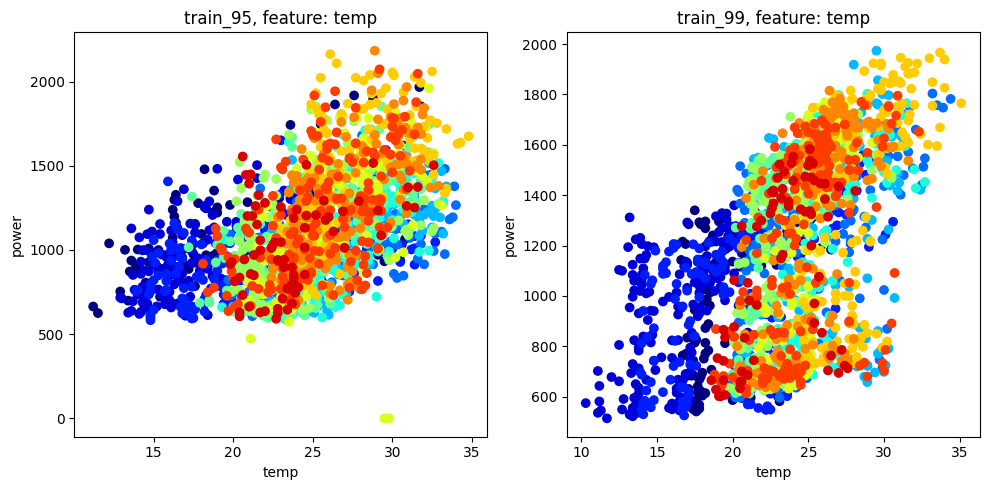

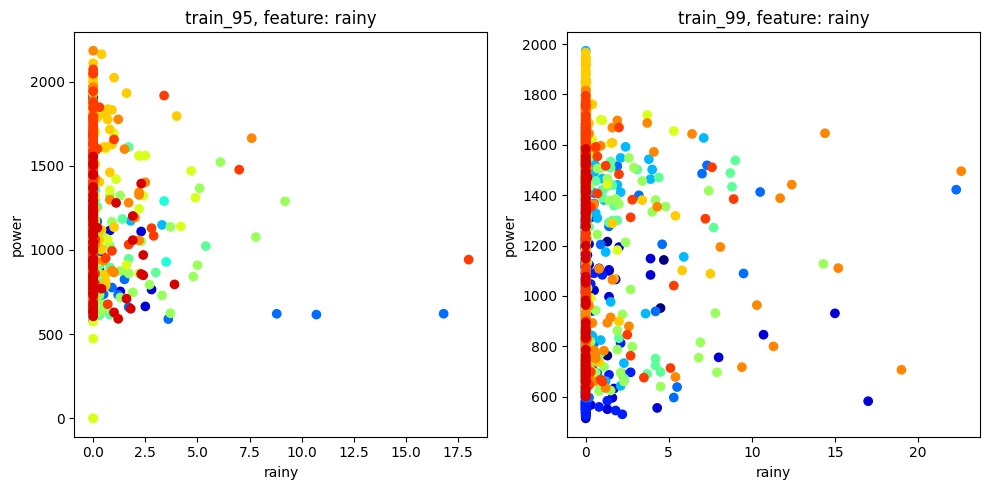

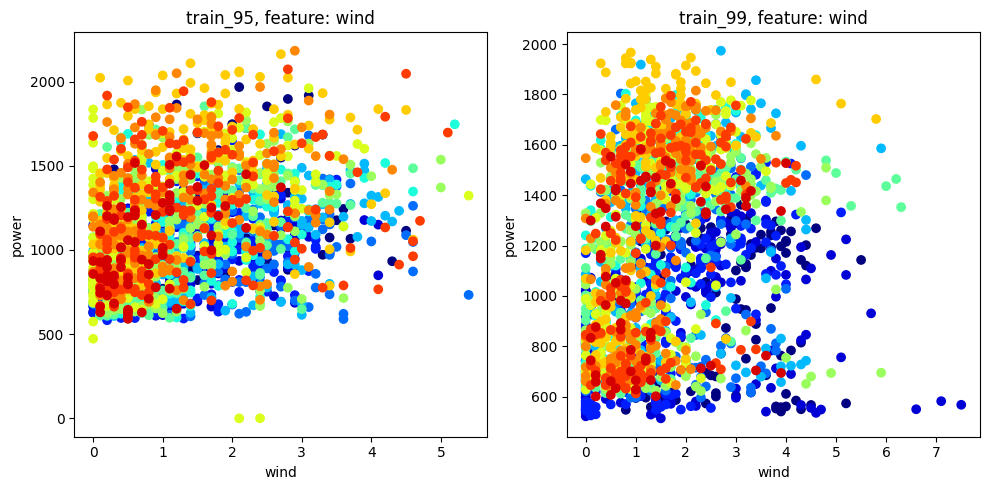

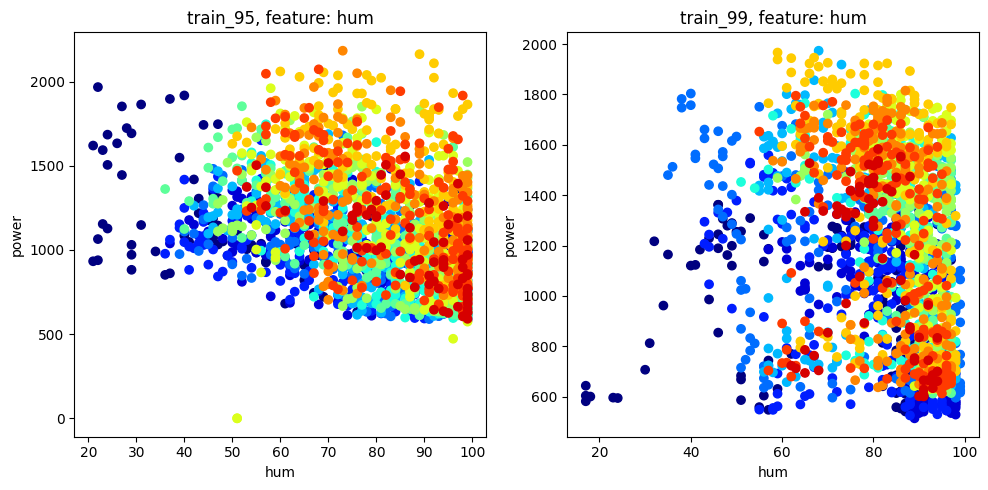

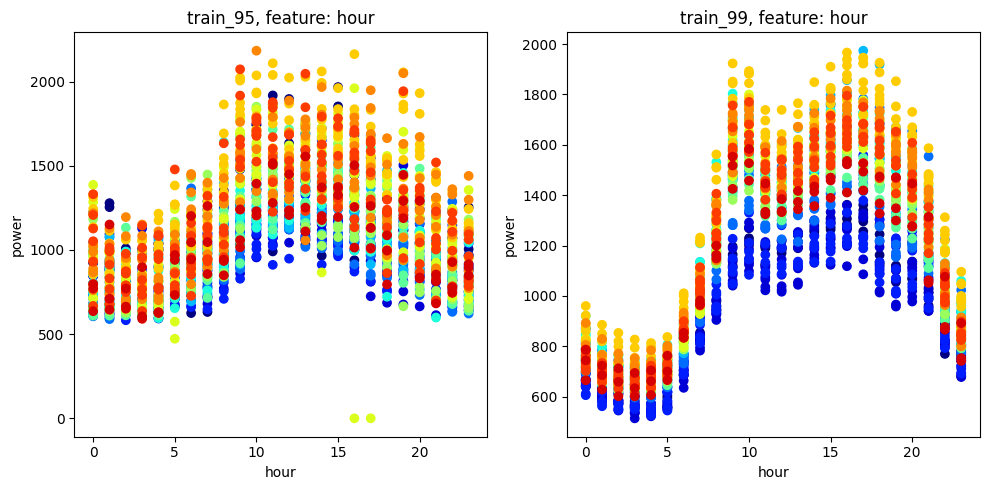

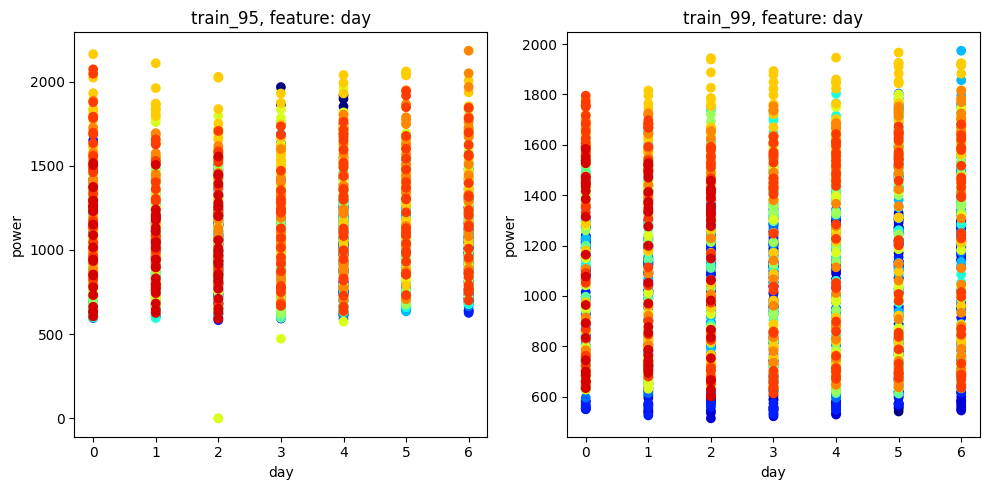

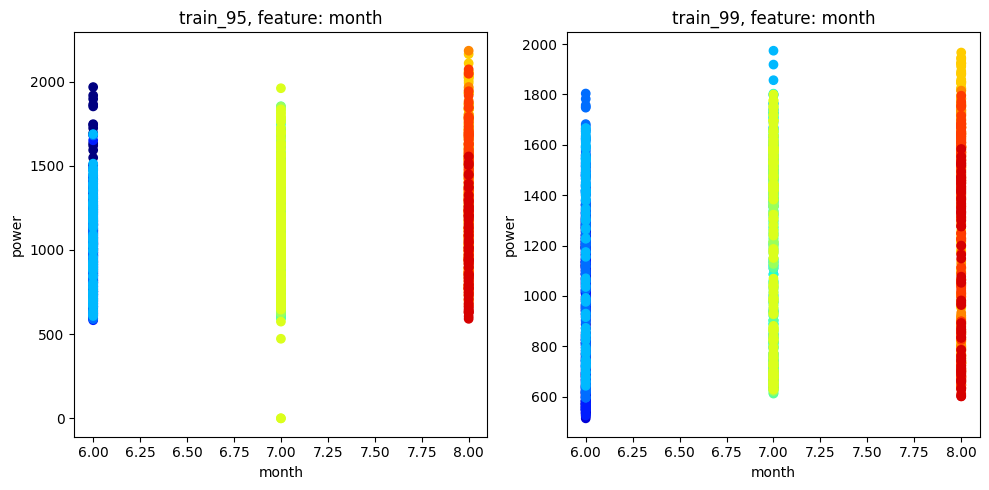

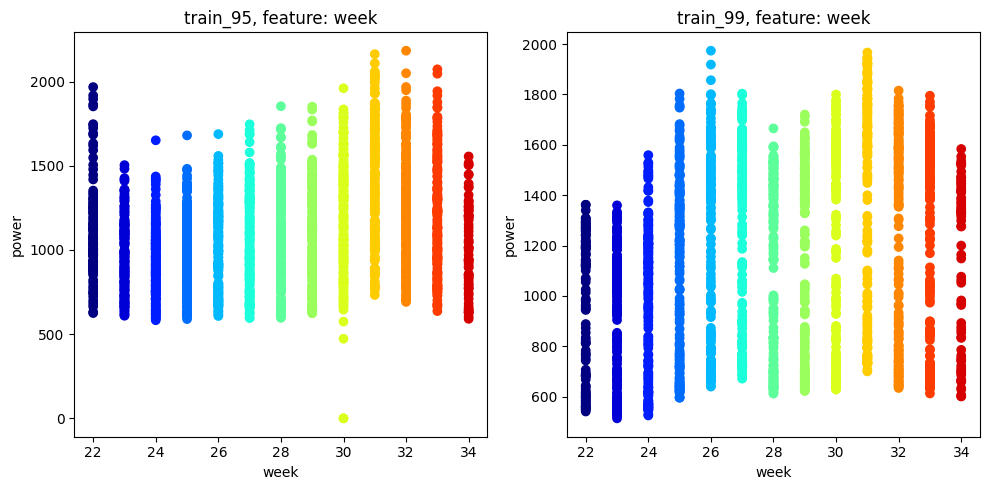

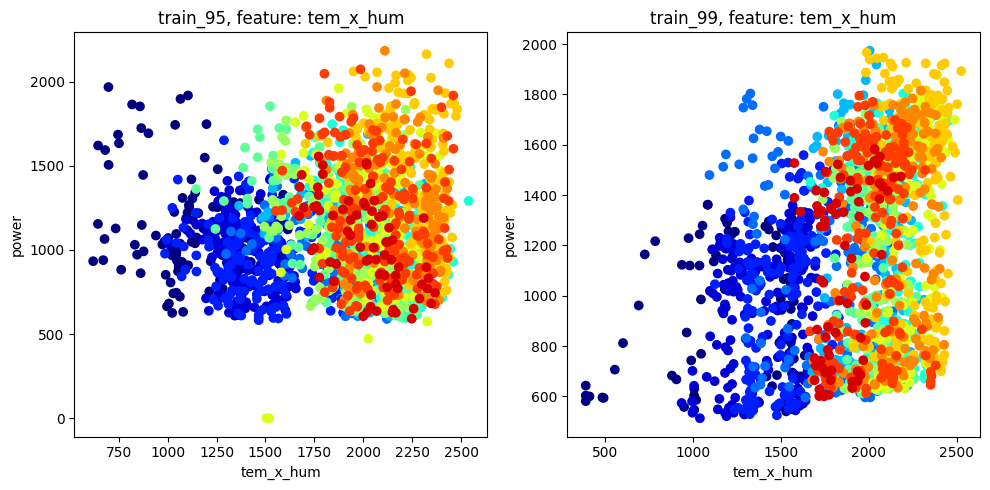

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_95 and train_99 have the same columns
# For each feature in the dataframe
for col in train_95.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_95[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

                # Check if week is in the subset
        if 'week' in train_95.columns:
            # Create a colormap based on the week
            cmap = plt.cm.jet
            # Normalize the week values between 0 and 1 for color mapping
            colors_95 = train_95['week'].apply(lambda x: cmap((x - 22) / 13.))
            colors_99 = train_99['week'].apply(lambda x: cmap((x - 22) / 13.))

        else:
            # Default color is blue
            colors_95 = 'b'
            colors_99 = 'b'

        # Plot a scatter plot for this feature and the target for train_95
        ax1.scatter(train_95[col], train_95['power'], c=colors_95)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_95, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_99
        ax2.scatter(train_99[col], train_99['power'], c=colors_99)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_99, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


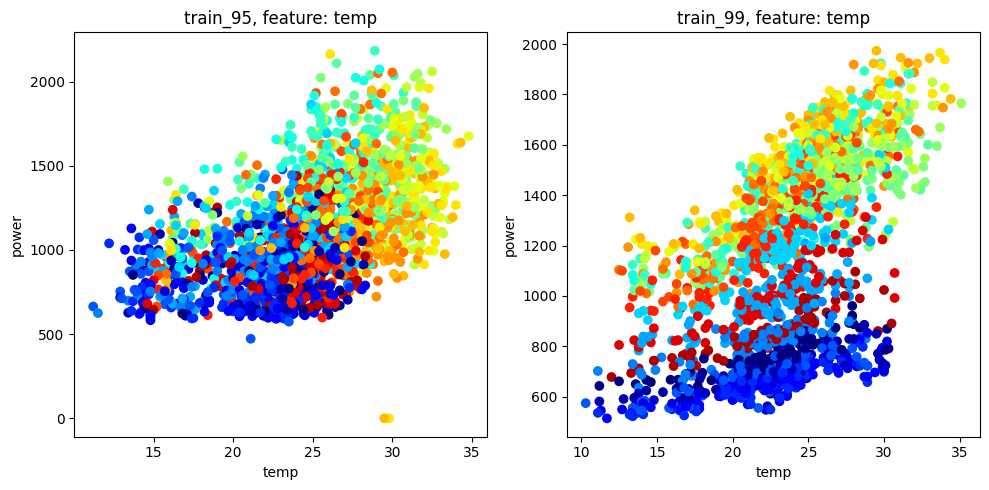

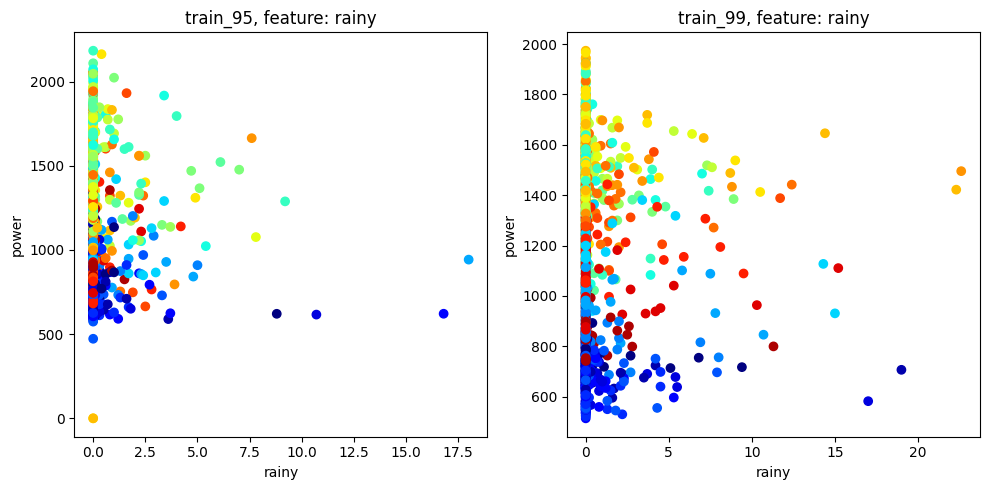

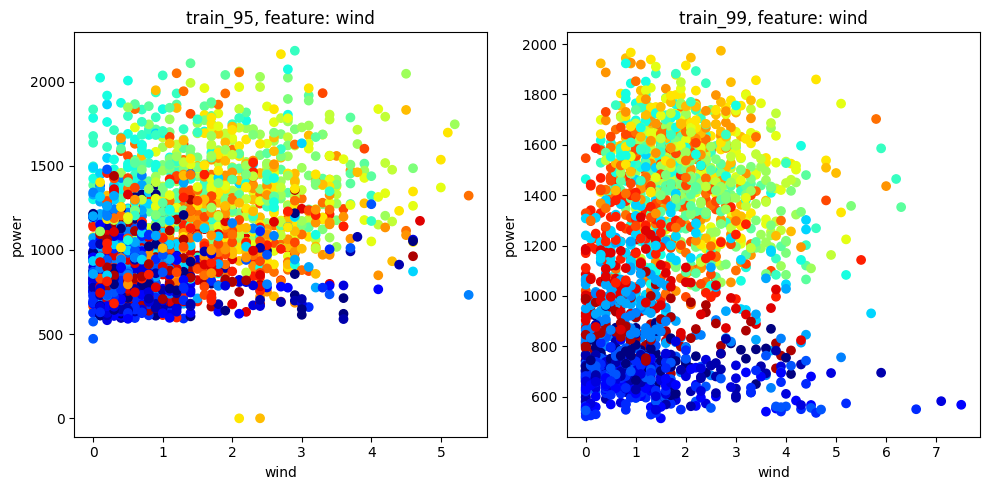

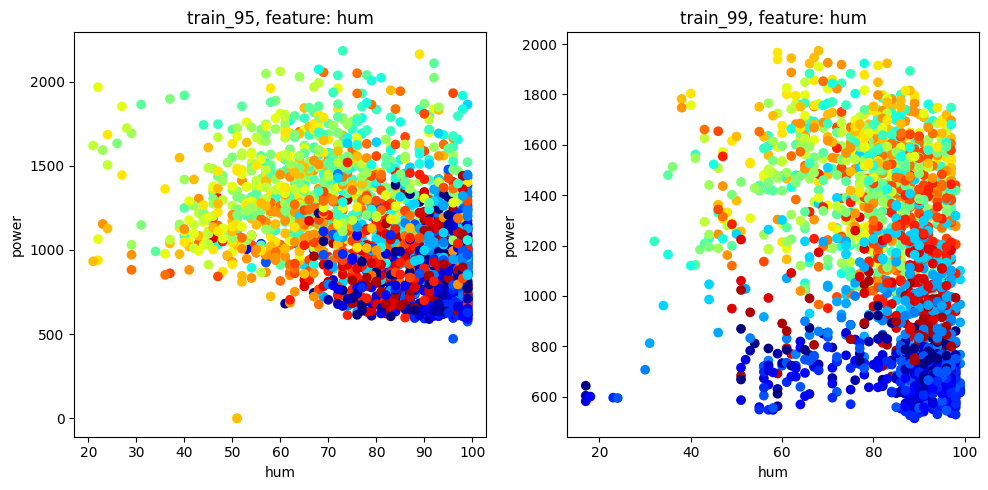

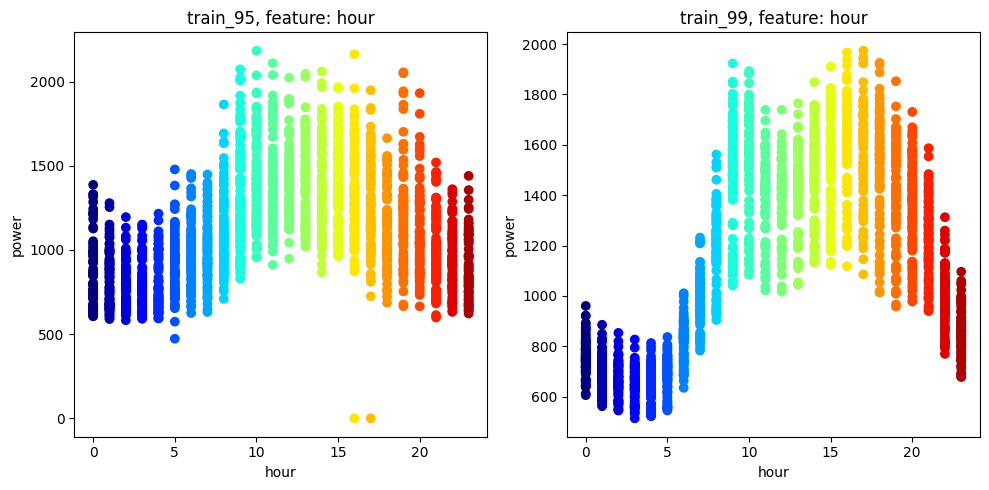

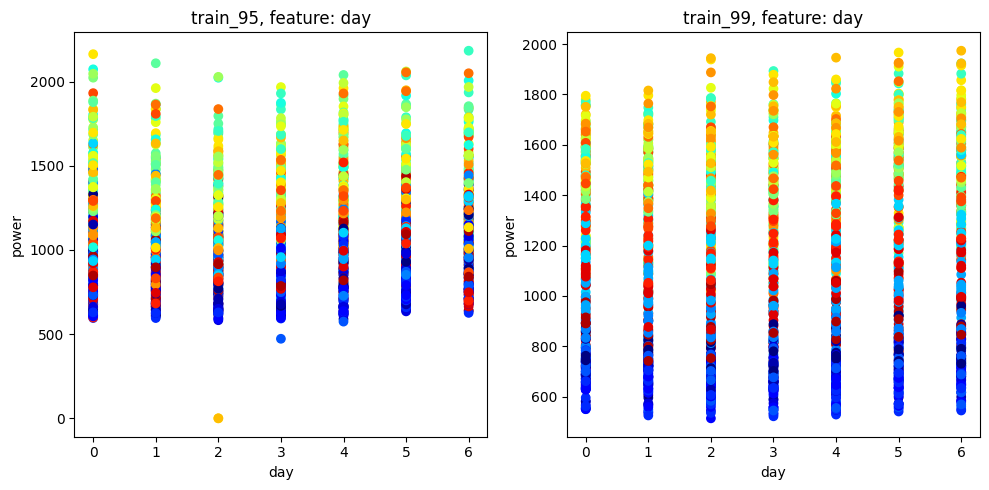

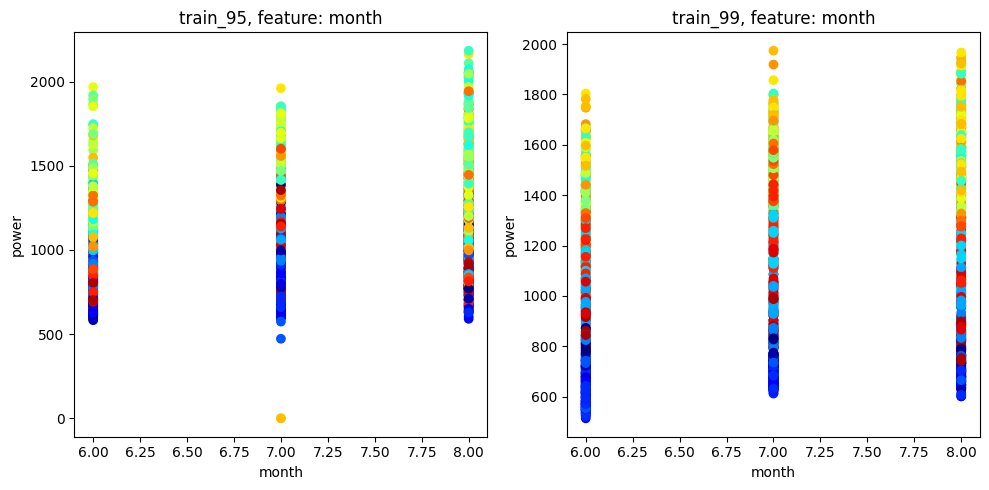

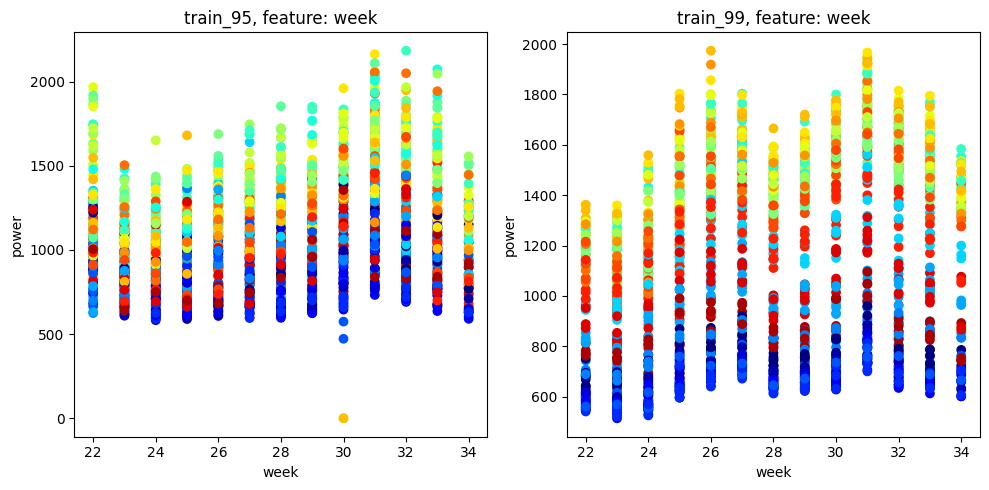

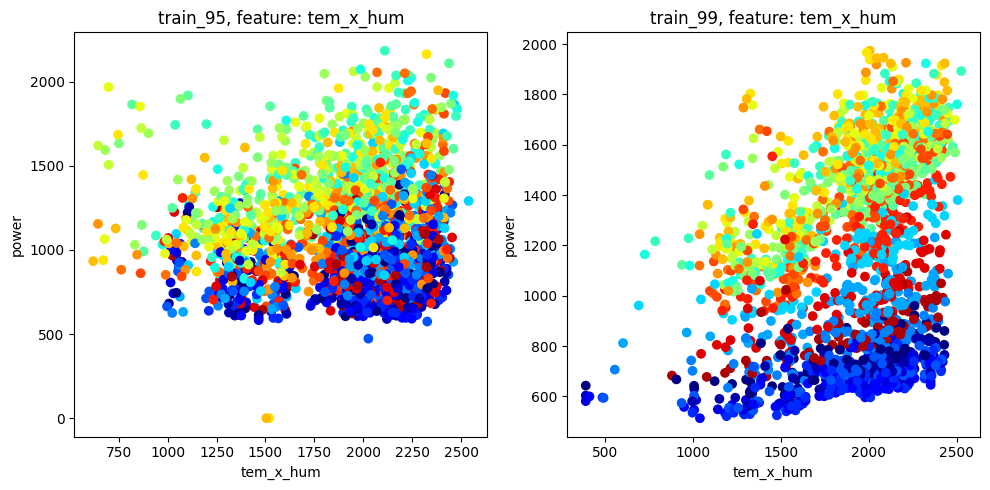

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

skip_features = ['num', 'group', 'group_target_mean']

# Assuming train_95 and train_99 have the same columns
# For each feature in the dataframe
for col in train_95.columns:

    # If it's a numerical feature and not the target and not in the skip list
    if np.issubdtype(train_95[col].dtype, np.number) and col != 'power' and col not in skip_features:

        # Create a new figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

                # Check if hour is in the subset
        if 'hour' in train_95.columns:
            # Create a colormap based on the hour
            cmap = plt.cm.jet
            # Normalize the hour values between 0 and 1 for color mapping
            colors_95 = train_95['hour'].apply(lambda x: cmap((x - 0) / 24.))
            colors_99 = train_99['hour'].apply(lambda x: cmap((x - 0) / 24.))

        else:
            # Default color is blue
            colors_95 = 'b'
            colors_99 = 'b'

        # Plot a scatter plot for this feature and the target for train_95
        ax1.scatter(train_95[col], train_95['power'], c=colors_95)
        ax1.set_xlabel(col)
        ax1.set_ylabel('power')
        ax1.set_title(f"train_95, feature: {col}")

        # Plot a scatter plot for this feature and the target for train_99
        ax2.scatter(train_99[col], train_99['power'], c=colors_99)
        ax2.set_xlabel(col)
        ax2.set_ylabel('power')
        ax2.set_title(f"train_99, feature: {col}")

        # Show the plot
        plt.tight_layout()
        plt.show()


In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.4 MB/s eta 0:

In [ ]:
from pycaret.regression import *

In [ ]:
train_95

num    date_time  temp  rainy  wind   hum    power  hour  day  month  \
0      95  20220601 00  16.5    0.0   1.4  61.0   681.48     0    2      6   
1      95  20220601 01  15.3    0.0   0.7  67.0   999.72     1    2      6   
2      95  20220601 02  14.5    0.0   1.1  70.0   806.40     2    2      6   
3      95  20220601 03  14.1    0.0   0.4  73.0   741.60     3    2      6   
4      95  20220601 04  13.9    0.0   0.9  76.0   897.84     4    2      6   
...   ...          ...   ...    ...   ...   ...      ...   ...  ...    ...   
2035   95  20220824 19  20.8    0.0   1.4  81.0  1446.12    19    2      8   
2036   95  20220824 20  20.4    0.0   0.5  87.0   836.64    20    2      8   
2037   95  20220824 21  20.1    0.0   0.2  92.0   813.96    21    2      8   
2038   95  20220824 22  19.9    0.0   0.1  92.0   928.08    22    2      8   
2039   95  20220824 23  19.8    0.0   0.8  94.0   915.84    23    2      8   

      week  group  tem_x_hum  group_target_mean  
0       22      9     1006.5        1112.192735  
1       22      9     1025.1        1112.192735  
2       22      9     1015.0        1112.192735  
3       22      9     1029.3        1112.192735  
4       22      9     1056.4        1112.192735  
...    ...    ...        ...                ...  
2035    34      9     1684.8        1112.192735  
2036    34      9     1774.8        1112.192735  
2037    34      9     1849.2        1112.192735  
2038    34      9     1830.8        1112.192735  
2039    34      9     1861.2        1112.192735  

[2040 rows x 14 columns]

In [ ]:
setup(train_14, target = 'power')

In [ ]:
!pip install catboost

In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
#compare_models(exclude = ['dt', 'rf','et', 'gbr' ,'ada'])
compare_models()

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

PassiveAggressiveRegressor(random_state=3105)